In [57]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdChemReactions as Reactions
from rdkit import RDLogger
#from compound_cacher import CompoundCacher
#from compound import Compound
#from chemaxon import *
#import chemaxon
import streamlit as st
import pandas as pd
import numpy as np
import re
from PIL import Image
import webbrowser
import json
import pickle
import sys
import joblib
import sys
import pulp
import os
import pdb
from tqdm import tqdm
import warnings
import shutil
import time
import itertools
import random

In [2]:
def count_substructures(radius, molecule):
    """Helper function for get the information of molecular signature of a
    metabolite. The relaxed signature requires the number of each substructure
    to construct a matrix for each molecule.
    Parameters
    ----------
    radius : int
        the radius is bond-distance that defines how many neighbor atoms should
        be considered in a reaction center.
    molecule : Molecule
        a molecule object create by RDkit (e.g. Chem.MolFromInchi(inchi_code)
        or Chem.MolToSmiles(smiles_code))
    Returns
    -------
    dict
        dictionary of molecular signature for a molecule,
        {smiles: molecular_signature}
    """
    m = molecule
    #m = Chem.AddHs(m)
    smi_count = {}
    atomList = [atom for atom in m.GetAtoms()]

    # Suppress RDKit warnings
    lg = RDLogger.logger()
    lg.setLevel(RDLogger.CRITICAL)

    for i in range(len(atomList)):
        atoms = set()
        env = None
        for r in range(radius, -1, -1):  # Decrease radius until 0
            env = Chem.FindAtomEnvironmentOfRadiusN(m, r, i)
            if env:
                break
        
        if env:
            for bidx in env:
                atoms.add(m.GetBondWithIdx(bidx).GetBeginAtomIdx())
                atoms.add(m.GetBondWithIdx(bidx).GetEndAtomIdx())
        else:
            atoms.add(i)  # Add the current atom index if no neighbors found at any radius

        # Convert atoms to smiles
        substructure = Chem.MolFragmentToSmiles(m, atomsToUse=list(atoms),
                                                bondsToUse=env, canonical=True, isomericSmiles=True)
        
        # Convert SMILES back to molecule
        sub_mol = Chem.MolFromSmiles(substructure)
        
        # Remove hydrogens if any
        if sub_mol:
            sub_mol = Chem.RemoveHs(sub_mol)
            # Convert back to SMILES
            substructure = Chem.MolToSmiles(sub_mol)
        
        if substructure in smi_count:
            smi_count[substructure] += 1
        else:
            smi_count[substructure] = 1
    return smi_count

In [3]:
def add_dicts(dict1, dict2):
    result_dict = {}
    # Iterate over the keys of the first dictionary
    for key in dict1:
        # Add the value from the first dictionary
        result_dict[key] = dict1[key]
        # If the key exists in the second dictionary, add its value as well
        if key in dict2:
            result_dict[key] += dict2[key]
    # Add keys from the second dictionary that are not in the first dictionary
    for key in dict2:
        if key not in dict1:
            result_dict[key] = dict2[key]
    for key, value in result_dict.copy().items():
        if value == 0:
            del result_dict[key]
    return result_dict



def subtract_dicts(dict1, dict2):
    result_dict = {}
    # Iterate over the keys of the first dictionary
    for key in dict1:
        # Subtract the value from the second dictionary if the key exists
        if key in dict2:
            result_dict[key] = dict1[key] - dict2[key]
        else:
            # If the key doesn't exist in the second dictionary, use the value from the first dictionary
            result_dict[key] = dict1[key]
    # Add keys from the second dictionary that are not in the first dictionary
    for key in dict2:
        if key not in dict1:
            # If the key doesn't exist in the first dictionary, use the negative of the value from the second dictionary
            result_dict[key] = -dict2[key]
    for key, value in result_dict.copy().items():
        if value == 0:
            del result_dict[key]
    return result_dict

In [4]:
def reaction_string_to_moiety_change_dict(reaction_string,radius):
    intial_state = reaction_string.split(">>")[0]
    final_state = reaction_string.split(">>")[1]
    
    intial_state_smiles = intial_state.split(".")
    final_state_smiles = final_state.split(".")
    
    if radius != 'MAX':
        state_i = {}
        for smile in intial_state_smiles:
            state_i = add_dicts(state_i,count_substructures(radius,Chem.MolFromSmiles(smile)))
            
        state_f = {}
        for smile in final_state_smiles:
            state_f = add_dicts(state_f,count_substructures(radius,Chem.MolFromSmiles(smile)))
        
        return subtract_dicts(state_f,state_i)
    else:
        state_i = {}
        for smile in intial_state_smiles:
            state_i = add_dicts(state_i,{smile : 1})

        state_f = {}
        for smile in final_state_smiles:
            state_f = add_dicts(state_f,{smile : 1})
            
        return subtract_dicts(state_f,state_i)

In [5]:
def atom_charge_makeup(smile,type):

    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    charge = Chem.GetFormalCharge(mol)
    Balance = {}
    if type == 'reactant':
        for atom in mol.GetAtoms():
            Balance = add_dicts(Balance,{atom.GetSymbol():-1})
            for k in range(atom.GetAtomicNum()):
                Balance = add_dicts(Balance,{'e':-1})
        if charge > 0:
            for k in range(abs(charge)):
                 Balance = add_dicts(Balance,{'e':1})
        elif charge < 0:
            for k in range(abs(charge)):
                 Balance = add_dicts(Balance,{'e':-1})
        return Balance
    elif type == 'product':
        for atom in mol.GetAtoms():
            Balance = add_dicts(Balance,{atom.GetSymbol():1})
            for k in range(atom.GetAtomicNum()):
                Balance = add_dicts(Balance,{'e':1})
        if charge > 0:
            for k in range(abs(charge)):
                 Balance = add_dicts(Balance,{'e':-1})
        elif charge < 0:
            for k in range(abs(charge)):
                 Balance = add_dicts(Balance,{'e':1})
        return Balance

In [6]:
def moiety_dict_to_reaction_smiles(dict):
    final = []
    intial = []
    for key, value in dict.copy().items():
        if value == 0:
            del result_dict[key]
        if value > 0:
            for k in range(abs(value)):
                final.append(key)
        if value < 0:
            for k in range(abs(value)):
                intial.append(key)
            
    Intial_state = '.'.join(intial)
    Final_state = '.'.join(final)
    
    return Intial_state + '>>' + Final_state

In [7]:
def reaction_atom_and_e_balance(reaction_smiles):
    
    intial_state = reaction_smiles.split(">>")[0]
    final_state = reaction_smiles.split(">>")[1]
                
    intial_state_smiles = intial_state.split(".")
    final_state_smiles = final_state.split(".")
        
    smiles = []
    mol_parts = []
    intial_state = []
    final_state = []
    for smile in intial_state_smiles:
        mol = Chem.MolFromSmiles(smile)
        mol = Chem.AddHs(mol)
        charge = Chem.GetFormalCharge(mol)
        Balance = {}
        for atom in mol.GetAtoms():
            Balance = add_dicts(Balance,{atom.GetSymbol():-1})
            for k in range(atom.GetAtomicNum()):
                Balance = add_dicts(Balance,{'e':-1})
        if charge > 0:
            for k in range(abs(charge)):
                 Balance = add_dicts(Balance,{'e':1})
        elif charge < 0:
            for k in range(abs(charge)):
                 Balance = add_dicts(Balance,{'e':-1})
        intial_state.append(Balance)
        mol_parts.append(Balance)
        smiles.append(smile)

                    
    state_f = []
    for smile in final_state_smiles:
        mol = Chem.MolFromSmiles(smile)
        mol = Chem.AddHs(mol)
        charge = Chem.GetFormalCharge(mol)
        Balance = {}
        for atom in mol.GetAtoms():
            Balance = add_dicts(Balance,{atom.GetSymbol():1})
            for k in range(atom.GetAtomicNum()):
                Balance = add_dicts(Balance,{'e':1})
        if charge > 0:
            for k in range(abs(charge)):
                Balance = add_dicts(Balance,{'e':-1})
        elif charge < 0:
            for k in range(abs(charge)):
                Balance = add_dicts(Balance,{'e':1})
        final_state.append(Balance)
        mol_parts.append(Balance)
        smiles.append(smile)
        
    intial = []    
    for smile in intial_state:
        intial = add_dicts(intial,smile)

    final = []    
    for smile in final_state:
        final = add_dicts(final,smile)
        
    Balance = add_dicts(final,intial)
    return Balance , mol_parts , smiles

In [8]:
def fix_rxn(reaction_num, leftover_string):
    return moiety_dict_to_reaction_smiles(subtract_dicts(reaction_string_to_moiety_change_dict(reaction_string[reaction_num],'MAX'),reaction_string_to_moiety_change_dict(leftover_string,'MAX')))


In [44]:
# Function to check if a given permutation keeps cumulative sum non-negative
def is_valid_permutation(perm):
    cumulative_sum = np.zeros(len(perm[0][1]))  # Start with a zero array for cumulative sum
    for _, lst in perm:
        cumulative_sum += np.array(lst)  # Add the current list element-wise
        if (cumulative_sum < 0).any():  # If any element of the cumulative sum goes negative
            return False
    return True

In [9]:
# Suppress RDKit warnings
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)


In [10]:
### get all overall reaction strings in database

reaction_str = []
for j in range(len(os.listdir('Mol_files'))):
    if j == 451 or j == 488:
        reaction_str.append('')
        continue
    else:
    
        reactant_smiles = []
        for r in range(len(os.listdir('Mol_files/' + str(j) + '/Reactants'))):
            # Iterate over each file path
            # Load the molecule from the MOL file
            molecule = Chem.rdmolfiles.MolFromMolFile('Mol_files/' + str(j) + '/Reactants/' + str(r) + '.mol')
            reactant_smiles.append(Chem.MolToSmiles(molecule,isomericSmiles = False))
            
        product_smiles = []
        for p in range(len(os.listdir('Mol_files/' + str(j) + '/Products'))):
            # Iterate over each file path
            # Load the molecule from the MOL file
            molecule = Chem.rdmolfiles.MolFromMolFile('Mol_files/' + str(j) + '/Products/' + str(p) + '.mol')
            product_smiles.append(Chem.MolToSmiles(molecule,isomericSmiles = False))
        
        
        
        smiles_1 = '.'.join(reactant_smiles)
        smiles_2 = '.'.join(product_smiles)
        reaction_str.append(smiles_1 + '>>' +smiles_2)

reaction_str

['[NH3+]C(CCC(=O)[O-])C(=O)[O-]>>[NH3+]C(CCC(=O)[O-])C(=O)[O-]',
 '*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)[O-].O>>*C(=O)NC(C(=O)O)C1NC(C(=O)[O-])C(C)(C)S1',
 'NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1.*C1=C(*)C(=O)C(*)=C(*)C1=O.[H+]>>NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.*c1c(*)c(O)c(*)c(*)c1O',
 'O=NO.[Cu+2].[H+]>>O.[N]=O.[Cu+]',
 'O.*C([NH3+])C(=O)NC(*)C(=O)[O-]>>*C([NH3+])C(=O)[O-].*C([NH3+])C(=O)[O-]',
 '[NH3+]C(CCC(=O)NC(CSSCC(NC(=O)CCC([NH3+])C(=O)[O-])C(=O)NCC(=O)[O-])C(=O)NCC(=O)[O-])C(=O)[O-].NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)C=CC1.[H+]>>[NH3+]C(CCC(=O)NC(CS)C(=O)NCC(=O)[O-])C(=O)[O-].NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1',
 'NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)(O)O)C3O)C(O)C2O)c1.O=C([O-])CC(C(=O)[O-])C(O)C(=O)[O-]>>O=C([O-])CCC(=O)C(=O)[O-].NC(=O)

In [11]:
### water acts as a cofactor and can be deleted 
reaction_str[549] = 'CC(=O)C(=O)[O-].O=CC(O)COP(=O)([O-])[O-]>>O=C([O-])C(=O)CC(O)C(O)COP(=O)([O-])[O-]'
reaction_str[606] = 'NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1>>[H+].NC(=O)c1cccnc1.N=c1c2ncn3c2ncn1C1OC(COP(=O)([O-])OP(=O)([O-])OCC2OC3C(O)C2O)C(O)C1O'
reaction_str[753] = '*OCC1OC(*)CC1OP(=O)([O-])O*>>*OCC1OC(*)CC1OP(=O)([O-])O*'
reaction_str[836] = 'Nc1ncnc2c1ncn2C1CC(O)C(COP(=O)(O)OC2CC(n3cnc4c(N)ncnc43)OC2COP(=O)(O)OC2CC(n3cnc4c(N)ncnc43)OC2COP(=O)(O)O)O1>>Nc1ncnc2c1ncn2C1CC(OP(=O)(O)OCC2OC(n3cnc4c(N)ncnc43)CC2OP(=O)(O)OCC2OC(n3cnc4c(N)ncnc43)CC2O)C(COP(=O)(O)O)O1'

### missing a hydron as product
reaction_str[201] = 'Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])C(O)C1O.*OC1CC(n2cnc3c(N)ncnc32)OC1COP(=O)([O-])O.*P(=O)(O)OCC1OC(n2cnc3c(N)ncnc32)CC1O>>O=P([O-])([O-])OP(=O)([O-])[O-].Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])[O-])C(O)C1O.*OC1CC(n2cnc3c(N)ncnc32)OC1COP(=O)(O)OC1CC(n2cnc3c(N)ncnc32)OC1COP(*)(=O)O.[H+]'
reaction_str[306] = 'Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])C(O)C1O.*C(=O)[O-].*NC(CS)C(*)=O>>O=P([O-])([O-])OP(=O)([O-])[O-].Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])[O-])C(O)C1O.*C(=O)OP(=O)([O-])OCC1OC(n2cnc3c(N)ncnc32)C(O)C1O.*NC(CSC(*)=O)C(*)=O.[H+]'
reaction_str[426] = 'C[S+](CCC([NH3+])C(=O)[O-])CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.*C1CC(O)C(COP(=O)(O)OC2CC(n3ccc(N)nc3=O)OC2COP(=O)(O)OC2CC(*)OC2COP(=O)(O)O)O1>>Nc1ncnc2c1ncn2C1OC(CSCCC(N)C(=O)O)C(O)C1O.*C1CC(O)C(COP(=O)(O)OC2CC(n3ccc(NC)nc3=O)OC2COP(=O)(O)OC2CC(*)OC2COP(=O)(O)O)O1.[H+]'

### missing a water as a reactant
reaction_str[658] = '*OCC1OC(n2c3c(n(C)c2=O)C(=O)NC(N)N3)CC1O*.O>>CN(C=O)c1c(N)nc(N)nc1O.*OCC1OC(O)CC1O*'

#Entry 450 two H+ added as products to balance out with 3' and 5' change made above
reaction_str[449] = '*OCC1OC(*)CC1O.*OP(=O)([O-])OC1CC(*)OC1COP(=O)([O-])O.NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1>>*OCC1OC(*)CC1OP(=O)([O-])OCC1OC(*)CC1OP(=O)([O-])O*.NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])[O-])C(O)C2O)c1.Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])[O-])C(O)C1O.[H+].[H+]'

#Entry 212 forces the right stioch by adding 5 [H+] as products
reaction_str[211] = 'N#N.Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])C(O)C1O.S1[Fe]S[Fe+]1.O>>S1[Fe+]S[Fe+]1.O=P([O-])([O-])O.[H][H].Nc1ncnc2c1ncn2C1OC(COP(=O)([O-])OP(=O)([O-])[O-])C(O)C1O.[H+].[H+].[H+].[H+].[H+].[H+].[NH4+]'

#Entry 938 di-mu-sulfido-diiron(2+) is a product not reactant
reaction_str[937] = 'C[S+](CCC([NH3+])C(=O)[O-])CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.S1[Fe]S[Fe+]1.*OC1C(COP(*)(=O)[O-])OC(n2cnc3c(N)ncnc32)C1O>>S1[Fe+]S[Fe+]1.*OC1C(COP(*)(=O)[O-])OC(n2cnc3c(N)nc(C)nc32)C1O.CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.Nc1ncnc2c1ncn2C1OC(CSCCC([NH3+])C(=O)[O-])C(O)C1O.CSCCC([NH3+])C(=O)[O-]'

#Entry 4 the copper ions are on wrong side of reaction
reaction_str[3] = 'O=NO.[Cu+].[H+]>>O.[N]=O.[Cu+2]'

#Entry 119 the ferredoxin is reduced twice to Fe+ not Fe+2
reaction_str[118] = '[Fe+3].CC(=O)C(=O)[O-].CC(C)(COP(=O)([O-])OP(=O)([O-])OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)([O-])[O-])C(O)C(=O)NCCC(=O)NCCS>>CC(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP(=O)([O-])OP(=O)([O-])OCC1OC(n2cnc3c(N)ncnc32)C(O)C1OP(=O)([O-])[O-].O=C=O.[Fe+].[H+]'

#Entry 278 hydrons cancel each other out to just have two on product side
reaction_str[277] = 'CC(C)=CCc1cc(O)c(C)c(C)c1O.[Cu+2]>>CC(C)=CCC1=CC(=O)C(C)=C(C)C1=O.[H+].[Cu+]'

#Entry 295 reaction should include the zinc complex like it does in mechanism
reaction_str[294] = 'CC[S-]->[Zn+2](<-[S-]CC)(<-SCC)<-SCC.*C1CC(OP(=O)([O-])OC)C(CO)O1>>CC[S-]->[Zn+2](<-SCC)(<-SCC)<-S(C)CC.*C1CC(OP(=O)([O-])[O-])C(CO)O1'

#Entry 374 2,4-dibromophenol is not the product of the mechanism, also 4-bromophenol swapped with 2-bromophenol in above code
# also OH- is made rather that H+ 
reaction_str[373] = '[Br-].OO.Oc1ccccc1>>[OH-].Oc1ccccc1Br.O'

#Entry 433 pullulan product deleted along with a change to it as a reactant in above code
reaction_str[432] = 'OCC1OC(OC2C(CO)OC(OC3C(CO)OC(OCC4OC(OC5C(CO)OC(OC6C(CO)OC(O)C(O)C6O)C(O)C5O)C(O)C(O)C4O)C(O)C3O)C(O)C2O)C(O)C(O)C1O.O>>O=CC(O)C(O)C(OC1OC(COC2OC(CO)C(O)C(O)C2O)C(O)C(O)C1O)C(O)CO'

#Entry 565 wrong products in reaction changed to products shown in mechanism also no H+ is made
reaction_str[564] = '*C1OC(COP(=O)(O)OC2C(COP(=O)(O)OC3C(CO)OC(*)C3O)OC(*)C2O)C(O)C1O.O>>*C1OC(COP(=O)(O)OC2C(CO)OC(*)C2O)C(OP(=O)(O)O)C1O.*C1OC(CO)C(O)C1O'
  
#Entry 785 water and OH3+ is used instead of H+  
reaction_str[784] = 'O.O=C([O-])C(O)COP(=O)([O-])[O-].NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1>>O=C([O-])C(=O)COP(=O)([O-])[O-].NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1.[OH3+]'

#Entry 978 ammonia is made not ammonium and mechanism uses only the head of FAD in mechanism also [OH3+] instead of [H+]
reaction_str[977] = 'NC(=[NH2+])NCCCC([NH3+])C(=O)[O-].O.*n1c2nc(=O)[nH]c(=O)c-2nc2cc(C)c(C)cc21>>NC(=[NH2+])NCCCC(=O)C(=O)[O-].N.*N1c2cc(C)c(C)cc2Nc2c1[n-]c(=O)[nH]c2=O.[OH3+]'

#Entry 995 Mn for some reason is a reactant in the API
reaction_str[994] = '[H+].O=O.O=C([O-])C(=O)[O-]>>OO.O=C=O'


In [12]:
########## Best fixes for the 7 reactions that could not be charge balanced ##########

#Entry 37 
# best fix add O2 and H+, drop the ROOH and ROH they do not show up in other databases linking from this entry
# still leaving 2 e left over?
reaction_str[36] = 'O=O.O=O.CCCCCC=CCC=CCC=CCC=CCCCC(=O)[O-].[H+].[H+]>>CCCCCC(O)C=CC1C2CC(OO2)C1CC=CCCCC(=O)[O-].O'

#Entry 372
# still leaving 2 e left over?

#Entry 416 
# best fix is to add two H+
# still removing 4 e?
reaction_str[415] = '*C1CC(O)C(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])O1.O.O=C[O-]>>[H+].[H+].[H+].*C1OC(COP(=O)([O-])OP(=O)([O-])OP(=O)([O-])[O-])C(O)C1O.O=C=O'

#Entry 473 
# best fix is to add oxidonitrate
# still leaving 2 e left over?
reaction_str[472] = 'N#[N+][O-].NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)c1.O>>[N-]=O.[N-]=O.[H+].NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4cnc5c(N)ncnc54)C(O)C3O)C(O)C2O)C=CC1'

#Entry 490 
# best fix to add NADPH(-4) and NADP(-3) to make up for the two Hs needed to be added to the reactant 
# still are removing two e?
reaction_str[489] = 'Nc1nc2c(c(=O)[nH]1)N=C(CNc1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1)CN2.NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1.NC(=O)C1=CN(C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)C=CC1>>Nc1nc2c(c(=O)[nH]1)NC(CNc1ccc(C(=O)NC(CCC(=O)O)C(=O)O)cc1)CN2.NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1.NC(=O)c1ccc[n+](C2OC(COP(=O)([O-])OP(=O)([O-])OCC3OC(n4cnc5c(N)ncnc54)C(OP(=O)([O-])[O-])C3O)C(O)C2O)c1'

#Entry 949 
# still leaving 2 e left over?

#Entry 965 
#"The exact product and hence mechanism of this enzyme is not yet known"
# best fix water acts as a cofactor add S-adenosyl-L-methionine and L-methionine 
# still are leaving 2 e left over?
reaction_str[964] = 'O=c1ccn(C2OC(COP(=O)(O)OP(=O)(O)OC3OC(CO)C(O)C(O)C3O)C(O)C2O)c(=O)[nH]1.C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.C[S+](CCC(N)C(=O)O)CC1OC(n2cnc3c(N)ncnc32)C(O)C1O>>CC1OC(n2cnc3c(N)ncnc32)C(O)C1O.CSCCC(N)C(=O)O.CSCCC(N)C(=O)O.Nc1ncnc2c1ncn2C1OC(COC2C(CO)OC(OP(=O)(O)OP(=O)(O)OCC3OC(n4ccc(=O)[nH]c4=O)C(O)C3O)C(O)C2O)C(O)C1O'



In [13]:
original_atoms = ['[1H+]','[1*]','[2*]','[3*]','[4*]','[5*]','[6*]']

fixed_atoms =  ['[H+]','*','*','*','*','*','*']

swap_dict = dict(zip(original_atoms, fixed_atoms))


for j in range(len(reaction_str)):
    if j == 451 or j == 488:
        continue
    else:       
        for key in swap_dict:
            if key in reaction_str[j]:
                reaction_str[j] = reaction_str[j].replace(key, swap_dict[key])

In [14]:
### Atom balance for overall reactions for each entry


W = 20
reaction_string = []
for j in tqdm(range(len(os.listdir('Mol_files')))):
    if j == 451 or j == 488:
        reaction_string.append('')
        continue
    else:    
        intial_state = reaction_str[j].split(">>")[0]
        final_state = reaction_str[j].split(">>")[1]
        
        intial_state_smiles = intial_state.split(".")
        final_state_smiles = final_state.split(".")

        states_smiles = []
        states = []
        state_i = []
        for smile in intial_state_smiles:
            mol = Chem.MolFromSmiles(smile)
            mol = Chem.AddHs(mol)
            charge = Chem.GetFormalCharge(mol)
            Balance = {}
            for atom in mol.GetAtoms():
                Balance = add_dicts(Balance,{atom.GetSymbol():-1})
                for i in range(atom.GetAtomicNum()):
                    Balance = add_dicts(Balance,{'e':-1})
            if charge > 0:
                for i in range(abs(charge)):
                     Balance = add_dicts(Balance,{'e':1})
            elif charge < 0:
                for i in range(abs(charge)):
                     Balance = add_dicts(Balance,{'e':-1})
            state_i.append(Balance)
            states.append(Balance)
            states_smiles.append(smile)
            
        state_f = []
        for smile in final_state_smiles:
            mol = Chem.MolFromSmiles(smile)
            mol = Chem.AddHs(mol)
            charge = Chem.GetFormalCharge(mol)
            Balance = {}
            for atom in mol.GetAtoms():
                Balance = add_dicts(Balance,{atom.GetSymbol():1})
                for i in range(atom.GetAtomicNum()):
                    Balance = add_dicts(Balance,{'e':1})
            if charge > 0:
                for i in range(abs(charge)):
                    Balance = add_dicts(Balance,{'e':-1})
            elif charge < 0:
                for i in range(abs(charge)):
                    Balance = add_dicts(Balance,{'e':1})
            state_f.append(Balance)
            states.append(Balance)
            states_smiles.append(smile)
            
        intial = []    
        for si in range(len(state_i)):
            intial = add_dicts(intial,state_i[si])

        final = []    
        for sf in range(len(state_f)):
            final = add_dicts(final,state_f[sf])
            
        atom_balance = add_dicts(final,intial)
        for key, value in atom_balance.copy().items():
            if value == 0:
                del atom_balance[key]
        
        if atom_balance == {}:
            reaction_string.append(reaction_str[j])
            continue
        else:
            dicts = states
            Atoms = set()
            # Collecting keys from each dictionary
            for d in dicts:
                Atoms.update(d.keys())
            Atoms = list(Atoms)
            
            for d in dicts:
                for key in Atoms:
                    if key not in d:
                        d[key] = 0
        
            
            
            
            num_c = [ str(c) for c in range(len(dicts))]
            ###### variables ######
            y = pulp.LpVariable.dicts("y_c", num_c, lowBound = 1, upBound = W, cat="Integer") 
            
            # create MILP problem
            lp_prob = pulp.LpProblem("AtomBalance for Entry " + str(j), pulp.LpMinimize)
                    
            ####### objective function ####
            lp_prob += pulp.lpSum([y[c] for c in num_c])
            
            ####### constraints ####
            # constraint 1: moiety change balance between reaction and mechanism
            for a in Atoms:
                lp_prob += (
                    pulp.lpSum([dicts[int(c)][a]*y[c]] for c in num_c)
                    == 0,
                    "Atom_balance_on_" + str(a)
                )
            
            
            # optimal output: lp file for debug
            lp_prob.writeLP('./test.lp')
                    
            lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))
            
            if pulp.LpStatus[lp_prob.status] == 'Optimal': 
                final_str = []
                intial_str = []
                for c in num_c:
                    if int(c) >= len(state_i):
                        for k in range(int(y[c].varValue)):
                            final_str.append(states_smiles[int(c)])
                    else:
                        for k in range(int(y[c].varValue)):
                            intial_str.append(states_smiles[int(c)])
                            
                smiles_1 = '.'.join(intial_str)
                smiles_2 = '.'.join(final_str)
                reaction_string.append(smiles_1 + '>>' +smiles_2)      
    
            else:
                reaction_string.append(reaction_str[j])
                continue

  0%|                                                                                                          | 0/1005 [00:00<?, ?it/s]/Users/adh5885/Applications/anaconda3/lib/python3.11/site-packages/pulp/pulp.py:1316: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [00:03<00:00, 312.51it/s]


In [15]:
### check for atom balance for overall reactions for each entry

l=0
for j in range(len(os.listdir('Mol_files'))):
    if j == 451 or j == 488:
        continue
    else:    
        intial_state = reaction_string[j].split(">>")[0]
        final_state = reaction_string[j].split(">>")[1]
        
        intial_state_smiles = intial_state.split(".")
        final_state_smiles = final_state.split(".")

        states_smiles = []
        states = []
        state_i = []
        for smile in intial_state_smiles:
            mol = Chem.MolFromSmiles(smile)
            mol = Chem.AddHs(mol)
            charge = Chem.GetFormalCharge(mol)
            Balance = {}
            for atom in mol.GetAtoms():
                Balance = add_dicts(Balance,{atom.GetSymbol():-1})
                for i in range(atom.GetAtomicNum()):
                    Balance = add_dicts(Balance,{'e':-1})
            if charge > 0:
                for i in range(abs(charge)):
                     Balance = add_dicts(Balance,{'e':1})
            elif charge < 0:
                for i in range(abs(charge)):
                     Balance = add_dicts(Balance,{'e':-1})
            state_i.append(Balance)
            states.append(Balance)
            states_smiles.append(smile)
            
        state_f = []
        for smile in final_state_smiles:
            mol = Chem.MolFromSmiles(smile)
            mol = Chem.AddHs(mol)
            charge = Chem.GetFormalCharge(mol)
            Balance = {}
            for atom in mol.GetAtoms():
                Balance = add_dicts(Balance,{atom.GetSymbol():1})
                for i in range(atom.GetAtomicNum()):
                    Balance = add_dicts(Balance,{'e':1})
            if charge > 0:
                for i in range(abs(charge)):
                    Balance = add_dicts(Balance,{'e':-1})
            elif charge < 0:
                for i in range(abs(charge)):
                    Balance = add_dicts(Balance,{'e':1})
            state_f.append(Balance)
            states.append(Balance)
            states_smiles.append(smile)
            
        intial = []    
        for si in range(len(state_i)):
            intial = add_dicts(intial,state_i[si])

        final = []    
        for sf in range(len(state_f)):
            final = add_dicts(final,state_f[sf])
            
        atom_balance = add_dicts(final,intial)
        for key, value in atom_balance.copy().items():
            if value == 0:
                del atom_balance[key]
        
        if atom_balance != {}:
            l+=1
            print('Entry '+str(j+1)+' off by ' + str(atom_balance))
l

Entry 37 off by {'e': 2}
Entry 372 off by {'e': 2}
Entry 416 off by {'e': -4}
Entry 473 off by {'e': 2}
Entry 490 off by {'e': -2}
Entry 949 off by {'e': 2}
Entry 965 off by {'e': 2}


7

In [16]:
### get all mechanism step strings in database

# Initialize a list to store SMILES strings
entry_strings = []
for j in tqdm(range(len(os.listdir('Mech_files')))):
    if j == 451 or j == 488:
        entry_strings.append('')
        continue
    else:         
        mech_strings = []
        for i in range(len(os.listdir('Mech_files/'+ str(j)))):
            if os.path.exists('Mech_files/'+ str(j) + '/' + str(i)):
                step_strings = []
                for s in range(len(os.listdir('Mech_files/' + str(j) + '/' + str(i)))):
                    prod_mol_file = 'Prod_Mech_files/' + str(j) + '/' + str(i) + '/' + str(s) + '.mol'
                    if os.path.exists(prod_mol_file):
                        mol = Chem.rdmolfiles.MolFromMolFile(prod_mol_file)
                        if mol:
                            smiles_p = Chem.MolToSmiles(mol,isomericSmiles = False)
                        mol_file = 'Mech_files/' + str(j) + '/' + str(i) + '/' + str(s) + '.mol'
                        if os.path.exists(mol_file):
                            mol = Chem.rdmolfiles.MolFromMolFile(mol_file)
                            if mol:
                                smiles_r = Chem.MolToSmiles(mol,isomericSmiles = False)
                                
                            step_str = smiles_r + '>>' + smiles_p
                            step = reaction_string_to_moiety_change_dict(step_str,"MAX")
                                
                            intial_state_str = []
                            final_state_str = []
                            for key, value in step.items():
                                if value < 0:
                                    for k in range(abs(value)):
                                        intial_state_str.append(key)
                                if value > 0:
                                    for k in range(abs(value)):
                                        final_state_str.append(key)
                            smiles_i = '.'.join(intial_state_str)
                            smiles_f = '.'.join(final_state_str)
                            step_strings.append(smiles_i + '>>' +smiles_f)
                mech_strings.append(step_strings)
            else:
                continue    
        entry_strings.append(mech_strings)
                    
                    
       



100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [00:55<00:00, 18.15it/s]


In [17]:
# fixes all entries where the smiles are not in their canonical form
for j in range(len(entry_strings)):
    if j == 451 or j == 488:
        continue
    else:
        intial_state = reaction_string[j].split(">>")[0]
        final_state = reaction_string[j].split(">>")[1]
        
        intial_state_smiles = intial_state.split(".")
        final_state_smiles = final_state.split(".")

        for n in range(len(final_state_smiles)):
            final_state_smiles[n] = Chem.MolToSmiles(Chem.MolFromSmiles(final_state_smiles[n]))
                
        for n in range(len(intial_state_smiles)):
            intial_state_smiles[n] = Chem.MolToSmiles(Chem.MolFromSmiles(intial_state_smiles[n]))


        smiles_i = '.'.join(intial_state_smiles)
        smiles_f = '.'.join(final_state_smiles)
        reaction_string[j] = smiles_i + '>>' +smiles_f
          
        for i in range(len(entry_strings[j])): 
            if entry_strings[j][i] == []:
                continue 
            else:
                overall_mechanism = []
                for s in range(len(entry_strings[j][i])):
                    intial_state = entry_strings[j][i][s].split(">>")[0]
                    final_state = entry_strings[j][i][s].split(">>")[1]
                    
                    intial_state_smiles = intial_state.split(".")
                    final_state_smiles = final_state.split(".")
            
                    for n in range(len(final_state_smiles)):
                        final_state_smiles[n] = Chem.MolToSmiles(Chem.MolFromSmiles(final_state_smiles[n]))
                            
                    for n in range(len(intial_state_smiles)):
                        intial_state_smiles[n] = Chem.MolToSmiles(Chem.MolFromSmiles(intial_state_smiles[n]))
            
            
                    smiles_i = '.'.join(intial_state_smiles)
                    smiles_f = '.'.join(final_state_smiles)
                    entry_strings[j][i][s] = smiles_i + '>>' +smiles_f


In [19]:
radius = 'MAX'
MCSA_mols = []
for j in tqdm(range(len(reaction_string))):
    if j == 451 or j == 488 : ### empty entries
        MCSA_mols.append({})
        continue
    else:  
        if entry_strings[j][0] != []:
            MCSA_mols.append(reaction_string_to_moiety_change_dict(reaction_string[j],radius)) 
            
unique_frozensets = {frozenset(d.items()) for d in MCSA_mols}
unique_dicts_list = [dict(fs) for fs in unique_frozensets]
print(len(unique_dicts_list))  

with open('MCSA_mols_r'+str(radius)+'_unique.json', "w") as file:
   json.dump(unique_dicts_list, file)


100%|███████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [00:00<00:00, 108919.03it/s]

591


In [20]:
#entries with leftover reactions that only involve water, OH-, OH3+, or H+
water_only_entries = [5 ,7 ,21 ,35 ,49 ,69 ,73 ,92 ,111 ,115 ,150 ,200 ,210 ,215 ,222 ,311 ,316 ,318 ,325 ,331 ,332 ,335 ,338 
                      ,345 ,349 ,352, 364 ,484 ,524 ,525 ,526 ,565 ,570 ,583 ,587 ,592 ,603 ,614 ,619 ,620 ,645 ,662 ,690 ,720
                      ,760 ,764 ,782 ,800 ,810 ,842 ,983]

# entries only missing resetting of residues and the above
residue_reset_entries = [0, 78, 156, 219, 268 ,310 ,341 ,396 ,471 ,492 ,515 ,523 ,536 ,568 ,612 ,641 ,759 ,802 ,832 ,971, 1002]

# entries only off by a protonation of a product or reactant and the above
proton_entries = [11, 15 ,22 ,27 ,34 ,37 ,48 ,64 ,65 ,66 ,74 ,77 ,79 ,82 ,83 ,85 ,91 ,93 ,95 ,97 ,99 
                  ,127 ,148 ,157 ,151 ,167 ,170 ,171 ,172 ,174 ,176 ,177 ,178 ,179 ,180 ,195 ,197 ,198
                  ,201 ,213 ,217 ,223 ,228 ,229 ,242 ,243 ,244 ,245 ,246 ,248 ,265 ,279 ,281 ,286 ,287 ,298 ,291 ,295 ,299
                  ,300 ,301 ,302 ,304 ,312 ,313 ,317 ,336 ,339 ,343 ,347 ,355 ,362 ,368 
                  ,454 ,517 ,518 ,519 ,522 ,527 ,528 ,531 ,532 ,533 ,540 ,545 ,567 ,578 ,591 
                  ,607 ,618 ,623 ,626 ,630 ,631 ,634 ,635 ,646 ,649 ,665 ,670 ,677 ,678 ,680 ,683 ,686
                  ,702 ,704 ,707 ,715 ,717 ,722 ,730 ,739 ,740 ,747 ,751 ,756 ,769 ,777 ,780 
                  ,803 ,806 ,828 ,840 ,843 ,865 
                  ,915 ,921 ,949 ,950 ,951 ,955 ,970 ,1003]

# entries where the products or reactants are different then in the mech and the above
diff_species_entries = [4 ,10 ,16 ,18 ,25 ,26 ,40 ,41 ,44 ,52 ,58 ,70 ,75 ,94 ,146 ,159 ,160 ,162 ,163 ,164 ,169 ,173 ,183 ,184 ,190 
                        ,191 ,193 ,196 ,204 ,208 ,232 ,247 ,254 ,233 ,234 ,235 ,266 ,250 ,282 ,283 ,285 ,292 ,307 ,308 ,309 ,315 ,319 
                        ,320 ,330 ,337 ,342 ,351 ,384 ,406 ,450 ,509 ,511 ,516 ,541 ,554 ,566 ,569 ,573 ,581
                        ,609 ,616 ,632 ,644 ,648 ,653 ,660 ,666 ,672 ,674 ,679 ,692 ,695 
                        ,724 ,725 ,727 ,744 ,753 ,770 ,774 ,783 ,790 ,792 ,793 ,799
                        ,822 ,825 ,831 ,835 ,836 ,837 ,838 ,872 ,889 ,890 
                        ,909 ,941 ,946 ,973 ,974 ,975 ,981 ,982 ,988 ,991 ,993 ,995 ,998 ,999 ,1004]

fixed_entries = water_only_entries + residue_reset_entries + proton_entries + diff_species_entries

# sets up a new variable to store reactions that a fixed 
rxn_string = []
for j in range(len(reaction_string)):
    if j == 451 or j == 488:
        rxn_string.append('')
    else:   
        rxn_string.append(reaction_string[j])
        
# finds leftover reactions and uses that to fix the overall reaction so it accurately equates to the mechanism
radius = 'MAX'
i = 0 # always first mech 
for j in fixed_entries:   
    overall_reaction = reaction_string_to_moiety_change_dict(rxn_string[j],radius)
    overall_mechanism = []
    for s in range(len(entry_strings[j][i])):
        overall_mechanism = add_dicts(overall_mechanism,reaction_string_to_moiety_change_dict(entry_strings[j][i][s],radius))
    Balance = moiety_dict_to_reaction_smiles(subtract_dicts(overall_reaction , overall_mechanism))
    if Balance != '>>':
        Bal , mol_parts , smiles = reaction_atom_and_e_balance(Balance)
        if Bal == {}:
            rxn_string[j] = fix_rxn(j,Balance)


In [21]:
### check for atom balance for each step 

l = 0
v = 0
for j in range(len(entry_strings)):
    if j == 451 or j == 488:
        continue
    else:    
        for i in range(len(entry_strings[j])):
            for s in range(len(entry_strings[j][i])):
                atom_balance, mol_parts, smiles  = reaction_atom_and_e_balance(entry_strings[j][i][s])
                if atom_balance != {}:
                    l+=1
                    #print('#Entry '+str(j+1)+' Mech '+str(i+1  )+' Step '+str(s+1)+' off by ' + str(atom_balance))
                else:
                    v+=1
                    
print(l)
print(v)
print(l/v)

616
3023
0.2037710883228581


In [22]:
df = pd.read_csv('cofactor_changes.csv')
unlabeled_cofactors = df['unlabeled'].tolist()
labeled_cofactors = df['labeled'].tolist()

In [23]:

for c in range(len(unlabeled_cofactors)):
    for j in range(len(entry_strings)):
        if j == 451 or j == 488:
            continue
        else:   
            reactants_smiles, products_smiles = rxn_string[j].split('>>')
            reactants_list = reactants_smiles.split('.')
            products_list = products_smiles.split('.')
            
            updated_reactants_list = [labeled_cofactors[c] if item == unlabeled_cofactors[c] else item for item in reactants_list]
            updated_products_list = [labeled_cofactors[c] if item == unlabeled_cofactors[c] else item for item in products_list]
      
            rxn_string[j] = '.'.join(updated_reactants_list) + '>>' + '.'.join(updated_products_list)
            for i in range(len(entry_strings[j])):
                for s in range(len(entry_strings[j][i])):
                    reactants_smiles, products_smiles = entry_strings[j][i][s].split('>>')
                    reactants_list = reactants_smiles.split('.')
                    products_list = products_smiles.split('.')
                    
                    updated_reactants_list = [labeled_cofactors[c] if item == unlabeled_cofactors[c] else item for item in reactants_list]
                    updated_products_list = [labeled_cofactors[c] if item == unlabeled_cofactors[c] else item for item in products_list]
              
                    entry_strings[j][i][s] = '.'.join(updated_reactants_list) + '>>' + '.'.join(updated_products_list)
                    

In [24]:
Total = 0
num_fixed = 0
num_broken = 0
radius = 'MAX'
for j in tqdm(range(len(entry_strings))):
    if j == 451 or j == 488:
        continue
    else:
        overall_reaction = reaction_string_to_moiety_change_dict(rxn_string[j],radius)
        for i in range(len(entry_strings[j])): 
            if entry_strings[j][i] == []:
                continue 
            else:
                Total += 1
                overall_mechanism = []
                for s in range(len(entry_strings[j][i])):
                    overall_mechanism = add_dicts(overall_mechanism,reaction_string_to_moiety_change_dict(entry_strings[j][i][s],radius))
                Balance = subtract_dicts(overall_reaction , overall_mechanism)
                string = moiety_dict_to_reaction_smiles(Balance)
                if string == '>>':
                    num_fixed += 1
                else:
                    num_broken += 1

print('Total:',Total)
print('Number Fixed:',num_fixed)
print('Number Broken:',num_broken)
print('Fixed/Total:',num_fixed/Total)
print('Broken/Total:',num_broken/Total)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [00:00<00:00, 55592.89it/s]

Total: 882
Number Fixed: 553
Number Broken: 329
Fixed/Total: 0.626984126984127
Broken/Total: 0.373015873015873


In [25]:
radius = 1

In [845]:
MCSA_rules = []
for j in tqdm(range(len(entry_strings))):
    if j == 451 or j == 488 :
        MCSA_rules.append({})
        continue
    else:   
        mechs = []
        for i in range(len(entry_strings[j])):
            steps = []
            for s in range(len(entry_strings[j][i])):
                steps.append(reaction_string_to_moiety_change_dict(entry_strings[j][i][s],radius))   
            mechs.append(steps)
    MCSA_rules.append(mechs)

with open('MCSA_rules_r'+str(radius)+'_1005.json', "w") as file:
    json.dump(MCSA_rules, file)
len(MCSA_rules)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [04:11<00:00,  3.99it/s]


1005

In [846]:
MCSA_mols = []
for j in tqdm(range(len(rxn_string))):
    if j == 451 or j == 488 : ### empty entries
        MCSA_mols.append({})
        continue
    else:  
        MCSA_mols.append(reaction_string_to_moiety_change_dict(rxn_string[j],radius)) 
     
with open('MCSA_mols_r'+str(radius)+'_1005.json', "w") as file:
   json.dump(MCSA_mols, file)
len(MCSA_mols)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1005/1005 [01:20<00:00, 12.44it/s]


1005

In [26]:
with open('MCSA_rules_r'+str(radius)+'_1005.json', "r") as file:
    MCSA_rules = json.load(file)

In [27]:
with open('MCSA_mols_r'+str(radius)+'_1005.json', "r") as file:
    MCSA_mols = json.load(file)

In [28]:
MCSA_rules_valid = []
MCSA_rules_invalid = []
Rules = pd.DataFrame()
for j in range(len(MCSA_rules)):
    for i in range(len(MCSA_rules[j])):
        # add all steps
        for s in range(len(MCSA_rules[j][i])):
            net_step_change  = sum(MCSA_rules[j][i][s].values()) ### should be zero if the atoms between state are conserved 
            if net_step_change == 0:
                MCSA_rules_valid.append(MCSA_rules[j][i][s])
                print('M-CSA Entry ' + str(j+1) + ', Mechanism ' + str(i+1) + ', Step ' + str(s+1))
                df = pd.DataFrame(MCSA_rules[j][i][s], index=[str(j+1) + "_" + str(i+1) + "_" + str(s+1)])
                df = df.T
                Rules = pd.concat([Rules, df], axis=1)
            else:
                MCSA_rules_invalid.append(MCSA_rules[j][i][s])
                print('M-CSA Entry ' + str(j+1) + ', Mechanism ' + str(i+1) + ', Step ' + str(s+1) + ', off by ' + str(net_step_change) + ' Atoms')
                

# Fill missing values with 0
Rules= Rules.fillna(0).astype(int)
Rules

M-CSA Entry 1, Mechanism 1, Step 1
M-CSA Entry 1, Mechanism 1, Step 2
M-CSA Entry 1, Mechanism 1, Step 3
M-CSA Entry 1, Mechanism 1, Step 4
M-CSA Entry 2, Mechanism 1, Step 1
M-CSA Entry 2, Mechanism 1, Step 2
M-CSA Entry 2, Mechanism 1, Step 3
M-CSA Entry 2, Mechanism 1, Step 4
M-CSA Entry 2, Mechanism 1, Step 5
M-CSA Entry 2, Mechanism 2, Step 1
M-CSA Entry 2, Mechanism 2, Step 2
M-CSA Entry 2, Mechanism 2, Step 3
M-CSA Entry 2, Mechanism 2, Step 4
M-CSA Entry 2, Mechanism 2, Step 5
M-CSA Entry 3, Mechanism 1, Step 1
M-CSA Entry 3, Mechanism 1, Step 2
M-CSA Entry 3, Mechanism 1, Step 3
M-CSA Entry 3, Mechanism 1, Step 4
M-CSA Entry 4, Mechanism 1, Step 1
M-CSA Entry 4, Mechanism 1, Step 2
M-CSA Entry 4, Mechanism 1, Step 3
M-CSA Entry 4, Mechanism 1, Step 4
M-CSA Entry 4, Mechanism 1, Step 5
M-CSA Entry 4, Mechanism 1, Step 6
M-CSA Entry 4, Mechanism 1, Step 7, off by 1 Atoms
M-CSA Entry 4, Mechanism 1, Step 8
M-CSA Entry 4, Mechanism 2, Step 1, off by -1 Atoms
M-CSA Entry 4, Mechani

,1_1_1,1_1_2,1_1_3,1_1_4,2_1_1,2_1_2,2_1_3,2_1_4,2_1_5,2_2_1,...,1001_1_1,1001_1_2,1001_1_3,1002_1_2,1003_1_1,1003_1_2,1004_1_1,1005_1_1,1005_1_2,1005_1_3
[CH2:2][C:2](=[O:2])[OH:2],1,0,0,-1,1,0,-1,1,-1,0,...,1,0,-1,1,0,0,0,1,0,1
[C:2][OH:2],1,0,0,-1,1,0,-1,1,-1,0,...,1,0,-1,1,0,0,0,1,0,1
[CH3:4][CH2:4][S-:4],1,-1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[CH2:4][S-:4],1,-1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[CH3:4][CH2:4][SH:4],-1,1,-1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O[MnH4+2],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC([O-])(O)c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CC(O)(O)c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CO[ZnH3+2],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
m = 0
f = 0
Fixed_Entries = []
Rules = pd.DataFrame()
for j in range(len(MCSA_rules)):
    for i in range(len(MCSA_rules[j])):
        if MCSA_rules[j][i] != []:
            m += 1
            overall_mechanism = []
            for s in range(len(MCSA_rules[j][i])):
                overall_mechanism = add_dicts(overall_mechanism,MCSA_rules[j][i][s])
                
            Balance = subtract_dicts(MCSA_mols[j] , overall_mechanism)
            if Balance == {}:
                MCSA_rules_valid.append(MCSA_rules[j][i])
                print('M-CSA Entry: ' + str(j+1) + ', ' + 'Mechanism: ' + str(i+1))
                f += 1
                if j+1 not in Fixed_Entries:
                    Fixed_Entries.append(str(j+1) + '_' + str(i+1))
                for s in range(len(MCSA_rules[j][i])):
                    if moiety_dict_to_reaction_smiles(MCSA_rules[j][i][s]) == '>>':
                        continue
                    else:
                        df = pd.DataFrame(MCSA_rules[j][i][s], index=[str(j+1) + "_" + str(i+1) + "_" + str(s+1)])
                        df = df.T
                        Rules = pd.concat([Rules, df], axis=1)
print(f)                
# Fill missing values with 0
Rules= Rules.fillna(0).astype(int)
Rules

M-CSA Entry: 1, Mechanism: 1
M-CSA Entry: 2, Mechanism: 1
M-CSA Entry: 2, Mechanism: 2
M-CSA Entry: 5, Mechanism: 1
M-CSA Entry: 6, Mechanism: 1
M-CSA Entry: 7, Mechanism: 1
M-CSA Entry: 7, Mechanism: 2
M-CSA Entry: 7, Mechanism: 3
M-CSA Entry: 8, Mechanism: 1
M-CSA Entry: 9, Mechanism: 1
M-CSA Entry: 10, Mechanism: 1
M-CSA Entry: 11, Mechanism: 1
M-CSA Entry: 12, Mechanism: 1
M-CSA Entry: 15, Mechanism: 1
M-CSA Entry: 16, Mechanism: 1
M-CSA Entry: 17, Mechanism: 1
M-CSA Entry: 19, Mechanism: 1
M-CSA Entry: 21, Mechanism: 1
M-CSA Entry: 22, Mechanism: 1
M-CSA Entry: 23, Mechanism: 1
M-CSA Entry: 25, Mechanism: 1
M-CSA Entry: 26, Mechanism: 1
M-CSA Entry: 27, Mechanism: 1
M-CSA Entry: 27, Mechanism: 2
M-CSA Entry: 28, Mechanism: 1
M-CSA Entry: 31, Mechanism: 1
M-CSA Entry: 31, Mechanism: 2
M-CSA Entry: 32, Mechanism: 1
M-CSA Entry: 33, Mechanism: 1
M-CSA Entry: 35, Mechanism: 1
M-CSA Entry: 36, Mechanism: 1
M-CSA Entry: 38, Mechanism: 1
M-CSA Entry: 39, Mechanism: 1
M-CSA Entry: 40, Mec

,1_1_1,1_1_2,1_1_3,1_1_4,2_1_1,2_1_2,2_1_3,2_1_4,2_1_5,2_2_1,...,1000_1_1,1000_1_2,1001_1_1,1001_1_2,1001_1_3,1003_1_1,1003_1_2,1005_1_1,1005_1_2,1005_1_3
[CH2:2][C:2](=[O:2])[OH:2],1,0,0,-1,1,0,-1,1,-1,0,...,1,0,1,0,-1,0,0,1,0,1
[C:2][OH:2],1,0,0,-1,1,0,-1,1,-1,0,...,1,0,1,0,-1,0,0,1,0,1
[CH3:4][CH2:4][S-:4],1,-1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[CH2:4][S-:4],1,-1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[CH3:4][CH2:4][SH:4],-1,1,-1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC([O-])(O)c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c-c(c)[nH],0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cC([O-])C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
cC(O)C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
#number of unique rules
len(set(tuple(Rules[col]) for col in Rules))

1170

In [31]:
df = Rules



# Dictionary to store unique columns
unique_columns = {}
original_to_unique = {}

# Identify and store unique columns
for col in df:
    col_tuple = tuple(df[col])
    if col_tuple not in unique_columns.values():
        unique_columns[col] = col_tuple
        original_to_unique[col] = col  # Map original to itself initially
    else:
        # Find the unique column name that matches the current column
        for unique_col, unique_tuple in unique_columns.items():
            if unique_tuple == col_tuple:
                original_to_unique[col] = unique_col
                break

# Create a new DataFrame from the unique columns
Unique_Rules = pd.DataFrame(unique_columns, index=df.index)

# Create a dictionary to map unique column values to concatenated names
unique_to_concat = {unique_col: [] for unique_col in unique_columns.keys()}

# Populate the dictionary with original column names
for original_col, unique_col in original_to_unique.items():
    unique_to_concat[unique_col].append(original_col)

# Concatenate the names
unique_to_concat = {k: '&'.join(v) for k, v in unique_to_concat.items()}

# Rename the columns in the new DataFrame
Unique_Rules.rename(columns=unique_to_concat, inplace=True)

Unique_Rules

,1_1_1&525_1_1&680_1_2&803_1_1,1_1_2&335_1_1,1_1_3&335_1_2,1_1_4&182_1_3&182_2_3&328_1_4&680_1_6&803_1_5,2_1_1,2_1_2&2_2_2,2_1_3,2_1_4&2_2_4,2_1_5&2_2_5,2_2_1&301_1_1&635_1_1&724_1_1,...,997_2_2,997_2_3,997_3_2,997_3_3,999_1_1,1000_1_2,1001_1_3,1003_1_1,1003_1_2,1005_1_3
[CH2:2][C:2](=[O:2])[OH:2],1,0,0,-1,1,0,-1,1,-1,0,...,-1,0,-1,0,1,0,-1,0,0,1
[C:2][OH:2],1,0,0,-1,1,0,-1,1,-1,0,...,-1,0,-1,0,1,0,-1,0,0,1
[CH3:4][CH2:4][S-:4],1,-1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[CH2:4][S-:4],1,-1,1,-1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
[CH3:4][CH2:4][SH:4],-1,1,-1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CC([O-])(O)c,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,0,0,0,0,0,0,0
c-c(c)[nH],0,0,0,0,0,0,0,0,0,0,...,0,-1,0,-1,0,0,0,0,0,0
cC([O-])C,0,0,0,0,0,0,0,0,0,0,...,-1,0,0,0,0,0,0,0,0,0
cC(O)C,0,0,0,0,0,0,0,0,0,0,...,1,-1,0,0,0,0,0,0,0,0


In [32]:
Unique_Rules.columns.tolist()

['1_1_1&525_1_1&680_1_2&803_1_1',
 '1_1_2&335_1_1',
 '1_1_3&335_1_2',
 '1_1_4&182_1_3&182_2_3&328_1_4&680_1_6&803_1_5',
 '2_1_1',
 '2_1_2&2_2_2',
 '2_1_3',
 '2_1_4&2_2_4',
 '2_1_5&2_2_5',
 '2_2_1&301_1_1&635_1_1&724_1_1',
 '2_2_3&726_1_7',
 '5_1_1&94_1_1&169_1_1',
 '5_1_2&169_1_2&288_1_2&726_1_2&731_1_2',
 '5_1_3&169_1_3&173_1_2&238_1_2&608_1_2&609_1_2&688_1_2&723_1_2&798_1_2&821_3_2',
 '5_1_4&169_1_4&173_1_3&238_1_3&337_1_3&523_1_3&608_1_3&609_1_3&666_1_3&688_1_3&723_1_3&733_1_3&798_1_3&821_3_3',
 '5_1_5&169_1_5&173_1_4&238_1_4&337_1_4&523_1_4&608_1_4&609_1_4&666_1_4&688_1_4&723_1_4&733_1_4&798_1_4&821_3_4',
 '6_1_1',
 '6_1_2',
 '6_1_3',
 '6_1_4&77_1_1&594_1_1&619_1_1&746_1_1',
 '6_1_5',
 '6_1_6',
 '7_1_1&7_2_1&21_1_1',
 '7_1_2&7_2_2&7_3_3',
 '7_1_3&822_1_4',
 '7_2_3&7_3_4',
 '7_2_4&7_3_5&90_1_6&148_1_9&148_2_9&325_1_1&592_1_2',
 '7_3_1&8_1_1&76_1_1',
 '7_3_2&593_1_2',
 '8_1_2',
 '8_1_3',
 '8_1_4',
 '8_1_5&163_1_3&359_1_5&488_1_2&488_2_2&577_1_3&856_1_3',
 '8_1_6&50_1_3&50_2_3&331_1_5

In [33]:
Unique_Rules_list = Unique_Rules.columns.tolist()
rule_names = []
for Unique_Rule in Unique_Rules_list:
    mechanisms = Unique_Rule.split("&")
    names = []
    for step in mechanisms:
        entry = step.split("_")[0]
        mech = step.split("_")[1]
        names.append(entry + '_' + mech)
    rule_names.append(names)   

unique_rule_names = sorted(set(item for sublist in rule_names for item in sublist))

df = pd.DataFrame(0, index=unique_rule_names, columns=range(len(rule_names)))

for i, sublist in enumerate(rule_names):
    for item in sublist:
        df.at[item, i] = 1
        
unique_rule_matrix = df.to_dict(orient='index')

In [34]:

Fixed_Rxns = pd.DataFrame()
for l in range(len(Fixed_Entries)):
    j = int(Fixed_Entries[l].split("_")[0])
    i = int(Fixed_Entries[l].split("_")[1])
    if MCSA_mols[j-1] != {}:
        df = pd.DataFrame(MCSA_mols[j-1], index=[str(j) + '_' + str(i)])
        df = df.T
        Fixed_Rxns = pd.concat([Fixed_Rxns, df], axis=1)
    
Fixed_Rxns = Fixed_Rxns.fillna(0).astype(int)
df = Fixed_Rxns
# Dictionary to store unique columns
unique_columns = {}
original_to_unique = {}

# Identify and store unique columns
for col in df:
    col_tuple = tuple(df[col])
    if col_tuple not in unique_columns.values():
        unique_columns[col] = col_tuple
        original_to_unique[col] = col  # Map original to itself initially
    else:
        # Find the unique column name that matches the current column
        for unique_col, unique_tuple in unique_columns.items():
            if unique_tuple == col_tuple:
                original_to_unique[col] = unique_col
                break

# Create a new DataFrame from the unique columns
Unique_Fixed_Rxns = pd.DataFrame(unique_columns, index=df.index)

# Create a dictionary to map unique column values to concatenated names
unique_to_concat = {unique_col: [] for unique_col in unique_columns.keys()}

# Populate the dictionary with original column names
for original_col, unique_col in original_to_unique.items():
    unique_to_concat[unique_col].append(original_col)

# Concatenate the names
unique_to_concat = {k: '&'.join(v) for k, v in unique_to_concat.items()}

# Rename the columns in the new DataFrame
Unique_Fixed_Rxns.rename(columns=unique_to_concat, inplace=True)

Unique_Fixed_Rxns

,2_1&2_2&15_1&210_1&257_1&258_1&258_2&1001_1,5_1&168_1&169_1&173_1&175_1&177_1&238_1&241_1&266_1&288_1&396_1&595_1&608_1&609_1&624_1&635_1&676_1&678_1&679_1&688_1&718_1&723_1&724_1&731_1&746_1&747_1&789_1&798_1&805_1&806_1&814_1&815_1&816_1&818_1&820_1&821_1&821_2&821_3&830_1&917_1&964_1,6_1,7_1&7_2&7_3,8_1,9_1,10_1&947_1,11_1&27_1&27_2&28_1&41_1&42_1&160_1&161_1&163_1&163_2&164_1&165_1&321_1&338_1&530_1&564_1&565_1&577_1&693_1&727_1&791_1&794_1&812_1&832_1&836_1&838_1&839_1&856_1&904_1&955_1&989_1,12_1,16_1,...,983_1,984_1,992_1,994_1,996_1,997_1&997_2&997_3,999_1,1000_1,1003_1,1005_1
CNC,1,-1,0,0,0,0,0,0,1,1,...,0,0,0,0,-1,0,0,0,0,1
CC(=O)O,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CO,1,1,0,-1,0,-2,-1,1,0,0,...,-1,0,0,1,0,-2,-1,-1,0,0
CC(N)=O,-1,-1,0,0,0,0,0,0,0,-1,...,0,0,0,0,-1,0,0,0,0,0
CN(C)C,-1,0,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O=[PH]([O-])[O-],0,0,0,0,0,0,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
[O-][PH],0,0,0,0,0,0,0,0,0,0,...,0,-2,0,0,0,0,0,0,0,0
[cH:1][c:1]([CH3:1])[nH:1],0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
[cH:1][c:1]([CH3:1])[nH+:1],0,0,0,0,0,0,0,0,0,0,...,0,0,0,-1,0,0,0,0,0,0


In [35]:
old_names = Unique_Rules.columns.tolist()

new_names = list(range(len(old_names)))

column_mapping = dict(zip(old_names, new_names))
Unique_Rules_renamed = Unique_Rules.rename(columns=column_mapping)

In [36]:
moiety_index = Unique_Rules_renamed.index.tolist()  # moiety sets
rules_index = Unique_Rules_renamed.columns.values.tolist()
print("Number of unique rules used in this search:", len(rules_index))

###### parameters ######
    # T(m,r) contains atom stoichiometry for each rule
T = Unique_Rules_renamed.to_dict(orient="index")
T_abs = {key: {k: abs(v) for k, v in value.items()} for key, value in T.items()}

Number of unique rules used in this search: 1170


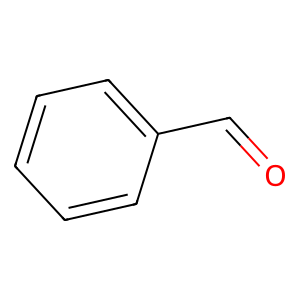

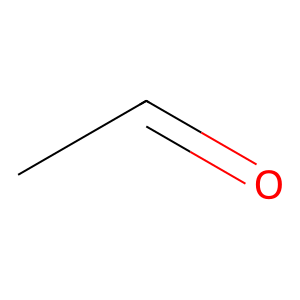

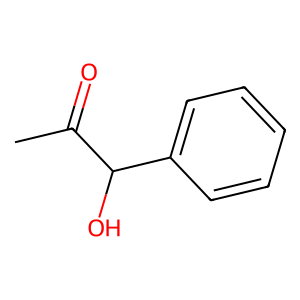

O=Cc1ccccc1.CC=O>>CC(=O)C(O)c1ccccc1


({},
 [{'O': -1, 'e': -56, 'C': -7, 'H': -6},
  {'C': -2, 'e': -24, 'O': -1, 'H': -4},
  {'C': 9, 'e': 80, 'O': 2, 'H': 10}],
 ['O=Cc1ccccc1', 'CC=O', 'CC(=O)C(O)c1ccccc1'])

In [39]:
string = 'c1ccccc1C=O.CC=O>>CC(=O)C(O)c1ccccc1'

intial = string.split(">>")[0]
final = string.split(">>")[1]
intial_smiles = intial.split(".")
final_smiles = final.split(".")
intial_smiles_new = []
final_smiles_new = []
for smile in intial_smiles:
    intial_smiles_new.append(Chem.MolToSmiles(Chem.MolFromSmiles(smile),isomericSmiles = False))
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(smile)] , molsPerRow=1, subImgSize=(300, 300)))
for smile in final_smiles:
    final_smiles_new.append(Chem.MolToSmiles(Chem.MolFromSmiles(smile),isomericSmiles = False))
    display(Draw.MolsToGridImage([Chem.MolFromSmiles(smile)] , molsPerRow=1, subImgSize=(300, 300)))
new_string = '>>'.join(['.'.join(intial_smiles_new),'.'.join(final_smiles_new)])
print(new_string)
reaction_atom_and_e_balance(new_string)


In [48]:
###### MechFind ###### 
j = 6 # reaction entry number
W = 20 # Max steps allowed 
iterations = 50 # Max integer cuts

reaction_string = 'c1ccccc1C=O.CC=O>>CC(=O)C(O)c1ccccc1' #rxn_string[j-1] # Can input any reaction string here
true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
T_EX = pd.DataFrame(true_rxn, index=['True Reaction'])
T_EX = T_EX.T


# Create a new DataFrame with one column and named rows from the vector of strings
C_m = {}
# Populate the dictionary with values from T_EX DataFrame
for index in moiety_index:
    if index in T_EX.index:
        C_m[index] = T_EX.loc[index, 'True Reaction']
    else:
        C_m[index] = 0.0


###### variables ######
y_rule = pulp.LpVariable.dicts("y", rules_index, lowBound=0, upBound=1, cat="Binary") 

# create MILP problem
lp_prob = pulp.LpProblem("MechFind", pulp.LpMinimize)

####### objective function ####
#lp_prob += pulp.lpSum([[T_abs[m][r] * y_rule[r] for r in rules_index] for m in moiety_index])
lp_prob += pulp.lpSum([y_rule[r] for r in rules_index])

####### constraints ####
# constraint 1: moiety change balance
for m in moiety_index:
    lp_prob += (
        pulp.lpSum([T[m][r] * y_rule[r] for r in rules_index ])
        == [C_m[m]],
        "moiety_balance_" + str(moiety_index.index(m))
    )
# constraint 2: customized constraints
# the number of steps of the pathway
lp_prob += pulp.lpSum([y_rule[r] for r in rules_index]) <= W

pbar = tqdm(total=iterations)
solutions = []
sol_num = 0
while len(solutions) < iterations:
    lp_prob.writeLP('./test.lp')
    lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

    if pulp.LpStatus[lp_prob.status] != 'Optimal':
        print('number of solutions:',sol_num)
        print('infeasible')
        break
    sol_num += 1
    integer_cut_rules = []
    s = 0
    for r in rules_index:
        if y_rule[r].varValue != 0:    
            s += 1

    solution = [] 
    for r in rules_index:
        if y_rule[r].varValue != 0:
            integer_cut_rules.append(r)
            solution.append(Unique_Rules.columns.tolist()[r])


    length = len(integer_cut_rules) - 1
    lp_prob += (
        pulp.lpSum([y_rule[r] for r in integer_cut_rules]) <= length,
        "integer_cut_" + str(sol_num),
    )
    
    mech  = solution
    reaction_string = rxn_string[j-1] 
    
    reactants = reaction_string.split('>>')[0]
    products = reaction_string.split('>>')[1]
    
    reactant_moieties = {}
    for reactant in reactants.split('.'):
        reactant_moieties = add_dicts(reactant_moieties,count_substructures(radius,Chem.MolFromSmiles(reactant)))
    reactant_df = pd.DataFrame.from_dict(reactant_moieties, orient='index')
    reactant_df.columns = ['Reactants']
    
    product_moieties = {}
    for product in products.split('.'):
        product_moieties = add_dicts(product_moieties,count_substructures(radius,Chem.MolFromSmiles(product)))
        
    product_df = pd.DataFrame.from_dict(product_moieties, orient='index')
    product_df.columns = ['Products']
    
    true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
    Mechanism  = pd.DataFrame.from_dict(true_rxn, orient='index')
    Mechanism.columns = ['RXN']
    
    Mechanism = pd.concat([Mechanism, reactant_df], axis=1)
    Mechanism = Mechanism.fillna(0).astype(int)
    
    for rule in mech:
        df = pd.DataFrame.from_dict(Unique_Rules[Unique_Rules[rule] != 0][rule].to_dict(), orient='index')
        df.columns = [rule]
        Mechanism = pd.concat([Mechanism, df], axis=1)
        Mechanism = Mechanism.fillna(0).astype(int)
    
    Mechanism = pd.concat([Mechanism, product_df], axis=1)
    Mechanism = Mechanism.fillna(0).astype(int)
    
    OR_moieties = list(true_rxn.keys())
    not_OR_moieties = list(set(Mechanism.index) - set(OR_moieties))
    intermediate_moieties = []
    labeled_moieties = []
    RP_cat_moieties = []
    unchanged_RP_moieties = []
    for moiety in not_OR_moieties:
        if ':' in moiety:
            atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
            labeled_atom_num = moiety.count(':')
            # this finds moieties that have labeled atoms but are not taken from labeled atoms 
            # only works for radius = 1 moieties 
            if len(atoms) != labeled_atom_num:
                if ':' not in atoms[1]:
                    intermediate_moieties.append(moiety) 
                else:
                    labeled_moieties.append(moiety)
            else:
                labeled_moieties.append(moiety)
        else:
            values = []
            for m in mech:
                values.append(abs(Mechanism.loc[moiety][m]))
            if sum(values) != 0:
                if Mechanism.loc[moiety]['Reactants'] != 0:
                    RP_cat_moieties.append(moiety)
                else:
                    intermediate_moieties.append(moiety)
            else:
                unchanged_RP_moieties.append(moiety)

    for moiety in OR_moieties:
        if Mechanism.loc[moiety]['Reactants'] == 0:
            intermediate_moieties.append(moiety)

    free_moieties = ['O','[OH3+]','[OH-]']
    intermediate_moieties = [moiety for moiety in intermediate_moieties if moiety not in free_moieties]

    mech_values = []
    for m in range(len(mech)):
        values = []
        for moiety in intermediate_moieties:
            values.append(Mechanism.loc[moiety][mech[m]])
        mech_values.append((m,values))
    
    # Check all permutations of the lists
    sorted_list = []
    for perm in itertools.permutations(mech_values):
        if is_valid_permutation(perm):
            for idx, lst in perm:
                sorted_list.append(mech[idx])
            break
    else:

        moieties_w_intermediate_residue_states = []
        for moiety in labeled_moieties:
            atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
            for atom in atoms:
                if atom == '[nH+:1]' or atom == '[OH:2]' or atom == '[NH:3]' or atom == '[S-:4]' or atom == '[NH2:5]' or atom == '[O-:6]' or atom == '[O-:7]' or atom == '[O-:29]' or atom == '[NH:29]':
                    moieties_w_intermediate_residue_states.append(moiety)
        
        intermediate_moieties = intermediate_moieties + moieties_w_intermediate_residue_states

        mech_values = []
        for m in range(len(mech)):
            values = []
            for moiety in intermediate_moieties:
                values.append(Mechanism.loc[moiety][mech[m]])
            mech_values.append((m,values))
        
        # Check all permutations of the lists
        sorted_list = []
        for perm in itertools.permutations(mech_values):
            if is_valid_permutation(perm):
                for idx, lst in perm:
                    sorted_list.append(mech[idx])
                break
        else:
            continue
    solutions.append(sorted_list)
    pbar.update(1)
pbar.close()
solutions


  0%|                                                                                                            | 0/50 [00:00<?, ?it/s]

number of solutions: 0
infeasible


[]

In [46]:
sol_num

1

In [755]:
from collections import Counter
solution_scores = []
for solution in solutions:
    e_m_codes  = []
    for rules in solution:
        steps = rules.split('&')
        e_m_code = []
        for step in steps:
            entry = step.split('_')[0]
            mech = step.split('_')[1]
            e_m_code.append(entry + '_' + mech)
        unique_e_m_code = [item for item in e_m_code if e_m_code.count(item) == 1]
        e_m_codes = e_m_codes + unique_e_m_code
    codes_dict = dict(Counter(e_m_codes))
    solution_scores.append(codes_dict[max(codes_dict, key=codes_dict.get)]/len(solution))

sorted_pairs = sorted(zip(solution_scores, solutions), reverse=True)

for solution_score, solution_list in sorted_pairs:
    print(f"Score: {solution_score}\nSteps: {len(solution_list)}\nSolution: {solution_list}\n")

Score: 1.0
Steps: 6
Solution: ['6_1_1', '6_1_2', '6_1_3', '6_1_4&77_1_1&594_1_1&619_1_1&746_1_1', '6_1_5', '6_1_6']

Score: 0.8
Steps: 5
Solution: ['627_1_1', '157_1_3&224_1_4&525_1_3', '627_1_2', '627_1_3', '627_1_4']

Score: 0.75
Steps: 4
Solution: ['6_1_4&77_1_1&594_1_1&619_1_1&746_1_1', '6_1_5', '6_1_6', '627_1_4']

Score: 0.6666666666666666
Steps: 6
Solution: ['6_1_5', '19_1_1&36_1_3&100_1_5&116_1_3&171_1_3&209_1_2&223_1_8&332_1_2&339_1_2&365_1_2&525_1_6&525_2_4&546_1_4&570_1_2&588_1_2&615_1_2&627_1_5&654_1_2&663_1_2&696_1_2&801_1_2&904_1_3&916_1_3&951_1_5', '80_1_3&229_1_5&236_1_3', '627_1_2', '627_1_3', '627_1_4']

Score: 0.6666666666666666
Steps: 6
Solution: ['39_1_2&87_2_2', '627_1_1', '291_1_3&292_1_7&629_1_4&704_1_4', '627_1_2', '627_1_3', '627_1_4']

Score: 0.6
Steps: 5
Solution: ['6_1_5', '39_1_2&87_2_2', '627_1_2', '627_1_3', '627_1_4']

Score: 0.6
Steps: 5
Solution: ['192_1_2', '627_1_1', '6_1_6', '627_1_3', '627_1_4']

Score: 0.5
Steps: 6
Solution: ['6_1_5', '19_1_1&36_

In [750]:
fails = 0
for solution in solutions:
    mech  = solution
    reaction_string = rxn_string[j-1] 
    
    reactants = reaction_string.split('>>')[0]
    products = reaction_string.split('>>')[1]
    
    reactant_moieties = {}
    for reactant in reactants.split('.'):
        reactant_moieties = add_dicts(reactant_moieties,count_substructures(radius,Chem.MolFromSmiles(reactant)))
    reactant_df = pd.DataFrame.from_dict(reactant_moieties, orient='index')
    reactant_df.columns = ['Reactants']
    
    product_moieties = {}
    for product in products.split('.'):
        product_moieties = add_dicts(product_moieties,count_substructures(radius,Chem.MolFromSmiles(product)))
        
    product_df = pd.DataFrame.from_dict(product_moieties, orient='index')
    product_df.columns = ['Products']
    
    true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
    Mechanism  = pd.DataFrame.from_dict(true_rxn, orient='index')
    Mechanism.columns = ['RXN']
    
    Mechanism = pd.concat([Mechanism, reactant_df], axis=1)
    Mechanism = Mechanism.fillna(0).astype(int)
    
    for rule in mech:
        df = pd.DataFrame.from_dict(Unique_Rules[Unique_Rules[rule] != 0][rule].to_dict(), orient='index')
        df.columns = [rule]
        Mechanism = pd.concat([Mechanism, df], axis=1)
        Mechanism = Mechanism.fillna(0).astype(int)
    
    Mechanism = pd.concat([Mechanism, product_df], axis=1)
    Mechanism = Mechanism.fillna(0).astype(int)
    
    OR_moieties = list(true_rxn.keys())
    not_OR_moieties = list(set(Mechanism.index) - set(OR_moieties))
    intermediate_moieties = []
    labeled_moieties = []
    RP_cat_moieties = []
    unchanged_RP_moieties = []
    for moiety in not_OR_moieties:
        if ':' in moiety:
            atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
            labeled_atom_num = moiety.count(':')
            # this finds moieties that have labeled atoms but are not taken from labeled atoms 
            # only works for radius = 1 moieties 
            if len(atoms) != labeled_atom_num:
                if ':' not in atoms[1]:
                    intermediate_moieties.append(moiety) 
                else:
                    labeled_moieties.append(moiety)
            else:
                labeled_moieties.append(moiety)
        else:
            values = []
            for m in mech:
                values.append(abs(Mechanism.loc[moiety][m]))
            if sum(values) != 0:
                if Mechanism.loc[moiety]['Reactants'] != 0:
                    RP_cat_moieties.append(moiety)
                else:
                    intermediate_moieties.append(moiety)
            else:
                unchanged_RP_moieties.append(moiety)
                
    for moiety in OR_moieties:
        if Mechanism.loc[moiety]['Reactants'] == 0:
            intermediate_moieties.append(moiety)


    free_moieties = ['O','[OH3+]','[OH-]']
    intermediate_moieties = [moiety for moiety in intermediate_moieties if moiety not in free_moieties]

    mech_values = []
    for m in range(len(mech)):
        values = []
        for moiety in intermediate_moieties:
            values.append(Mechanism.loc[moiety][mech[m]])
        mech_values.append((m,values))
    
    # Check all permutations of the lists
    sorted_list = []
    for perm in itertools.permutations(mech_values):
        if is_valid_permutation(perm):
            for idx, lst in perm:
                sorted_list.append(mech[idx])
            break
    else:

        moieties_w_intermediate_residue_states = []
        for moiety in labeled_moieties:
            atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
            for atom in atoms:
                if atom == '[nH+:1]' or atom == '[OH:2]' or atom == '[NH:3]' or atom == '[S-:4]' or atom == '[NH2:5]' or atom == '[O-:6]' or atom == '[O-:7]' or atom == '[O-:29]' or atom == '[NH:29]':
                    moieties_w_intermediate_residue_states.append(moiety)
        
        intermediate_moieties = intermediate_moieties + moieties_w_intermediate_residue_states

        for m in mech:
            values = []
            for moiety in intermediate_moieties: 
                values.append(abs(Mechanism.loc[moiety][m]))
            if sum(values) == 0:
                print()
                print(mech)
                print(m)
                print()
        mech_values = []
        for m in range(len(mech)):
            values = []
            for moiety in intermediate_moieties:
                values.append(Mechanism.loc[moiety][mech[m]])
            mech_values.append((m,values))
        
        # Check all permutations of the lists
        sorted_list = []
        for perm in itertools.permutations(mech_values):
            if is_valid_permutation(perm):
                for idx, lst in perm:
                    sorted_list.append(mech[idx])
                break
        else:
            
            print("No valid permutation found.")
            fails +=1
            print(mech)
        
fails

No valid permutation found.
['224_1_1&524_1_1&525_1_4&525_2_1&1005_1_1', '23_1_1&604_1_2&691_1_2&1005_1_2', '1005_1_3']
No valid permutation found.
['49_1_7&244_1_3', '350_1_1&604_1_1&691_1_1', '350_1_2', '1005_1_3']
No valid permutation found.
['49_1_7&244_1_3', '224_1_1&524_1_1&525_1_4&525_2_1&1005_1_1', '350_1_2', '604_1_4']
No valid permutation found.
['224_1_1&524_1_1&525_1_4&525_2_1&1005_1_1', '23_1_1&604_1_2&691_1_2&1005_1_2', '228_1_5&228_2_4&273_1_3', '604_1_4']
No valid permutation found.
['224_1_1&524_1_1&525_1_4&525_2_1&1005_1_1', '319_1_3&346_1_5', '350_1_2', '1005_1_3']
No valid permutation found.
['228_1_5&228_2_4&273_1_3', '350_1_1&604_1_1&691_1_1', '23_1_1&604_1_2&691_1_2&1005_1_2', '1005_1_3']
No valid permutation found.
['49_1_7&244_1_3', '224_1_1&524_1_1&525_1_4&525_2_1&1005_1_1', '23_1_1&604_1_2&691_1_2&1005_1_2', '255_1_1&604_1_3&604_1_6&604_1_9&691_1_3', '604_1_4']
No valid permutation found.
['8_1_6&50_1_3&50_2_3', '90_1_1&148_1_1&148_2_1&325_1_2&889_1_4', '224_

50

In [751]:
sorted_list

[]

In [771]:
mech  = ['627_1_1', '157_1_3&224_1_4&525_1_3', '627_1_2', '627_1_3', '627_1_4']

reaction_string = rxn_string[j-1] 

reactants = reaction_string.split('>>')[0]
products = reaction_string.split('>>')[1]

reactant_moieties = {}
for reactant in reactants.split('.'):
    reactant_moieties = add_dicts(reactant_moieties,count_substructures(radius,Chem.MolFromSmiles(reactant)))
reactant_df = pd.DataFrame.from_dict(reactant_moieties, orient='index')
reactant_df.columns = ['Reactants']

product_moieties = {}
for product in products.split('.'):
    product_moieties = add_dicts(product_moieties,count_substructures(radius,Chem.MolFromSmiles(product)))
    
product_df = pd.DataFrame.from_dict(product_moieties, orient='index')
product_df.columns = ['Products']

true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
Mechanism  = pd.DataFrame.from_dict(true_rxn, orient='index')
Mechanism.columns = ['RXN']

Mechanism = pd.concat([Mechanism, reactant_df], axis=1)
Mechanism = Mechanism.fillna(0).astype(int)

for rule in mech:
    df = pd.DataFrame.from_dict(Unique_Rules[Unique_Rules[rule] != 0][rule].to_dict(), orient='index')
    df.columns = [rule]
    Mechanism = pd.concat([Mechanism, df], axis=1)
    Mechanism = Mechanism.fillna(0).astype(int)

Mechanism = pd.concat([Mechanism, product_df], axis=1)
Mechanism = Mechanism.fillna(0).astype(int)

pd.options.display.max_rows = len(Mechanism)  

Mechanism


,RXN,Reactants,627_1_1,157_1_3&224_1_4&525_1_3,627_1_2,627_1_3,627_1_4,Products
CCC,-1,5,0,0,0,0,-1,4
CC(N)=O,-1,5,0,0,0,0,-1,4
CS,2,0,0,1,0,1,0,2
cC(N)=O,1,0,0,0,0,0,1,1
Cc(c)c,1,0,0,0,0,0,1,1
ccc,2,0,0,0,0,0,2,2
cc[n+],2,0,0,0,0,0,2,2
c[n+](C)c,1,0,0,0,0,0,1,1
CC([n+])O,1,0,0,0,0,0,1,1
[OH-],1,0,0,0,0,1,0,1


In [772]:
OR_moieties = list(true_rxn.keys())
not_OR_moieties = list(set(Mechanism.index) - set(OR_moieties))
intermediate_moieties = []
labeled_moieties = []
RP_cat_moieties = []
unchanged_RP_moieties = []
for moiety in not_OR_moieties:
    if ':' in moiety:
        atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
        labeled_atom_num = moiety.count(':')
        # this finds moieties that have labeled atoms but are not taken from labeled atoms 
        # only works for radius = 1 moieties 
        if len(atoms) != labeled_atom_num:
            if ':' not in atoms[1]:
                intermediate_moieties.append(moiety) 
            else:
                labeled_moieties.append(moiety)
        else:
            labeled_moieties.append(moiety)
    else:
        values = []
        for m in mech:
            values.append(abs(Mechanism.loc[moiety][m]))
        if sum(values) != 0:
            if Mechanism.loc[moiety]['Reactants'] != 0:
                RP_cat_moieties.append(moiety)
            else:
                intermediate_moieties.append(moiety)
        else:
            unchanged_RP_moieties.append(moiety)

for moiety in OR_moieties:
    if Mechanism.loc[moiety]['Reactants'] == 0:
        intermediate_moieties.append(moiety)


free_moieties = ['O','[OH3+]','[OH-]']
intermediate_moieties = [moiety for moiety in intermediate_moieties if moiety not in free_moieties]

intermediate_moieties

['C[S-]',
 'CC[S-]',
 'CS[S:4]',
 'CS',
 'cC(N)=O',
 'Cc(c)c',
 'ccc',
 'cc[n+]',
 'c[n+](C)c',
 'CC([n+])O']

In [773]:
for m in mech:
    values = []
    for moiety in intermediate_moieties: 
        values.append(Mechanism.loc[moiety][m])
    print(values)

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[-1, -1, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 1, -1, 0, 0, 0, 0, 0, 0, 0]
[-1, -1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 2, 2, 1, 1]


In [774]:

mech_values = []
for m in range(len(mech)):
    values = []
    for moiety in intermediate_moieties:
        values.append(Mechanism.loc[moiety][mech[m]])
    mech_values.append((m,values))
    print(values)

# Check all permutations of the lists
sorted_list = []
for perm in itertools.permutations(mech_values):
    if is_valid_permutation(perm):
        for idx, lst in perm:
            sorted_list.append(mech[idx])
        break
else:

    moieties_w_intermediate_residue_states = []
    for moiety in labeled_moieties:
        atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
        for atom in atoms:
            if atom == '[nH+:1]' or atom == '[OH:2]' or atom == '[NH:3]' or atom == '[S-:4]' or atom == '[NH2:5]' or atom == '[O-:6]' or atom == '[O-:7]' or atom == '[O-:29]' or atom == '[NH:29]':
                moieties_w_intermediate_residue_states.append(moiety)
    
    intermediate_moieties = intermediate_moieties + moieties_w_intermediate_residue_states

    for m in mech:
        values = []
        for moiety in intermediate_moieties: 
            values.append(abs(Mechanism.loc[moiety][m]))
        if sum(values) == 0:
            print()
            print(mech)
            print(m)
            print()
    mech_values = []
    for m in range(len(mech)):
        values = []
        for moiety in intermediate_moieties:
            values.append(Mechanism.loc[moiety][mech[m]])
        mech_values.append((m,values))
        print(values)
    # Check all permutations of the lists
    sorted_list = []
    for perm in itertools.permutations(mech_values):
        if is_valid_permutation(perm):
            for idx, lst in perm:
                sorted_list.append(mech[idx])
            break
    else:
        
        print("No valid permutation found.")
        fails +=1
        print(mech)

intermediate_moieties

[1, 1, 1, 0, 0, 0, 0, 0, 0, 0]
[-1, -1, 0, 1, 0, 0, 0, 0, 0, 0]
[1, 1, -1, 0, 0, 0, 0, 0, 0, 0]
[-1, -1, 0, 1, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 2, 2, 1, 1]


['C[S-]',
 'CC[S-]',
 'CS[S:4]',
 'CS',
 'cC(N)=O',
 'Cc(c)c',
 'ccc',
 'cc[n+]',
 'c[n+](C)c',
 'CC([n+])O']

In [770]:
intermediate_moieties = intermediate_moieties + moieties_w_intermediate_residue_states
intermediate_moieties 

['CS[S:4]',
 'CS',
 'cC(N)=O',
 'Cc(c)c',
 'ccc',
 'cc[n+]',
 'c[n+](C)c',
 'CC([n+])O',
 '[CH3:4][CH2:4][S-:4]',
 '[CH2:4][S-:4]',
 '[cH:1][c:1]([CH2:1])[nH+:1]',
 '[c:1][nH+:1][cH:1]',
 '[nH:1][cH:1][nH+:1]',
 '[C:2][OH:2]',
 '[CH2:2][C:2](=[O:2])[OH:2]']

In [51]:
labels = []
mech_vectors = []
Unique_Fixed_Rxns_List = Unique_Fixed_Rxns.columns.tolist()


for l in tqdm(range(len(Unique_Fixed_Rxns_List))):
    J = Unique_Fixed_Rxns_List[l].split("&")
    j = int(J[0].split("_")[0])
    W = 10 # Max steps allowed 
    iterations = 50 # Max integer cuts
    
    reaction_string = rxn_string[j-1] # Can input any reaction string here
    true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
    if true_rxn == {}:
        continue 
    else:
        T_EX = pd.DataFrame(true_rxn, index=['True Reaction'])
        T_EX = T_EX.T
        
        # Create a new DataFrame with one column and named rows from the vector of strings
        C_m = {}
        # Populate the dictionary with values from T_EX DataFrame
        for index in moiety_index:
            if index in T_EX.index:
                C_m[index] = T_EX.loc[index, 'True Reaction']
            else:
                C_m[index] = 0.0
        
        
        ###### variables ######
        y_rule = pulp.LpVariable.dicts("y", rules_index, lowBound=0, upBound=1, cat="Binary") 
        
        # create MILP problem
        lp_prob = pulp.LpProblem("MechFind", pulp.LpMinimize)
        
        ####### objective function ####
        #lp_prob += pulp.lpSum([[T_abs[m][r] * y_rule[r] for r in rules_index] for m in moiety_index])
        lp_prob += pulp.lpSum([y_rule[r] for r in rules_index])
        
        ####### constraints ####
        # constraint 1: moiety change balance
        for m in moiety_index:
            lp_prob += (
                pulp.lpSum([T[m][r] * y_rule[r] for r in rules_index ])
                == [C_m[m]],
                "moiety_balance_" + str(moiety_index.index(m))
            )
        # constraint 2: customized constraints
        # the number of steps of the pathway
        lp_prob += pulp.lpSum([y_rule[r] for r in rules_index]) <= W
        label = []
        mech_vector = []
        sol_num = 0
        start_time = time.time()
        while len(mech_vector) < iterations:
            sol_num += 1
            integer_cut_rules = []
            lp_prob.writeLP('./test.lp')
            lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

            end_time = time.time()  # Record end time
            elapsed_time = end_time - start_time
            if elapsed_time > 300:
                print(j,'took too long only got to', len(mech_vector), 'solution(s) in 5 mins' )
                break
                
            if pulp.LpStatus[lp_prob.status] != 'Optimal':
                print(j, 'only has', len(mech_vector), 'solution(s)' )
                break
                
            mechanism = []
            for r in rules_index:
                if y_rule[r].varValue != 0:
                    integer_cut_rules.append(r)
                    mechanism.append(Unique_Rules.columns.tolist()[r])

            length = len(integer_cut_rules) - 1
            lp_prob += (
                pulp.lpSum([y_rule[r] for r in integer_cut_rules]) <= length,
                "integer_cut_" + str(sol_num),
            )
            
            mech  = mechanism
            reactants = reaction_string.split('>>')[0]
            products = reaction_string.split('>>')[1]
            
            reactant_moieties = {}
            for reactant in reactants.split('.'):
                reactant_moieties = add_dicts(reactant_moieties,count_substructures(radius,Chem.MolFromSmiles(reactant)))
            reactant_df = pd.DataFrame.from_dict(reactant_moieties, orient='index')
            reactant_df.columns = ['Reactants']
            
            product_moieties = {}
            for product in products.split('.'):
                product_moieties = add_dicts(product_moieties,count_substructures(radius,Chem.MolFromSmiles(product)))
                
            product_df = pd.DataFrame.from_dict(product_moieties, orient='index')
            product_df.columns = ['Products']
            
            true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
            Mechanism  = pd.DataFrame.from_dict(true_rxn, orient='index')
            Mechanism.columns = ['RXN']
            
            Mechanism = pd.concat([Mechanism, reactant_df], axis=1)
            Mechanism = Mechanism.fillna(0).astype(int)
            
            for rule in mech:
                df = pd.DataFrame.from_dict(Unique_Rules[Unique_Rules[rule] != 0][rule].to_dict(), orient='index')
                df.columns = [rule]
                Mechanism = pd.concat([Mechanism, df], axis=1)
                Mechanism = Mechanism.fillna(0).astype(int)
            
            Mechanism = pd.concat([Mechanism, product_df], axis=1)
            Mechanism = Mechanism.fillna(0).astype(int)
            
            OR_moieties = list(true_rxn.keys())
            not_OR_moieties = list(set(Mechanism.index) - set(OR_moieties))
            intermediate_moieties = []
            labeled_moieties = []
            RP_cat_moieties = []
            unchanged_RP_moieties = []
            for moiety in not_OR_moieties:
                if ':' in moiety:
                    atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
                    labeled_atom_num = moiety.count(':')
                    # this finds moieties that have labeled atoms but are not taken from labeled atoms 
                    # only works for radius = 1 moieties 
                    if len(atoms) != labeled_atom_num:
                        if ':' not in atoms[1]:
                            intermediate_moieties.append(moiety) 
                        else:
                            labeled_moieties.append(moiety)
                    else:
                        labeled_moieties.append(moiety)
                else:
                    values = []
                    for m in mech:
                        values.append(abs(Mechanism.loc[moiety][m]))
                    if sum(values) != 0:
                        if Mechanism.loc[moiety]['Reactants'] != 0:
                            RP_cat_moieties.append(moiety)
                        else:
                            intermediate_moieties.append(moiety)
                    else:
                        unchanged_RP_moieties.append(moiety)
        
            for moiety in OR_moieties:
                if Mechanism.loc[moiety]['Reactants'] == 0:
                    intermediate_moieties.append(moiety)
        
            free_moieties = ['O','[OH3+]','[OH-]']
            intermediate_moieties = [moiety for moiety in intermediate_moieties if moiety not in free_moieties]
        
            mech_values = []
            for m in range(len(mech)):
                values = []
                for moiety in intermediate_moieties:
                    values.append(Mechanism.loc[moiety][mech[m]])
                mech_values.append((m,values))
            
            # Check all permutations of the lists
            sorted_list = []
            for perm in itertools.permutations(mech_values):
                if is_valid_permutation(perm):
                    for idx, lst in perm:
                        sorted_list.append(mech[idx])
                    break
            else:
        
                moieties_w_intermediate_residue_states = []
                for moiety in labeled_moieties:
                    atoms = re.findall(r'(\[.*?\]|\(.*?\)|[^-=#])', moiety)
                    for atom in atoms:
                        if atom == '[nH+:1]' or atom == '[OH:2]' or atom == '[NH:3]' or atom == '[S-:4]' or atom == '[NH2:5]' or atom == '[O-:6]' or atom == '[O-:7]' or atom == '[O-:29]' or atom == '[NH:29]':
                            moieties_w_intermediate_residue_states.append(moiety)
                
                intermediate_moieties = intermediate_moieties + moieties_w_intermediate_residue_states
        
                mech_values = []
                for m in range(len(mech)):
                    values = []
                    for moiety in intermediate_moieties:
                        values.append(Mechanism.loc[moiety][mech[m]])
                    mech_values.append((m,values))
                
                # Check all permutations of the lists
                sorted_list = []
                for perm in itertools.permutations(mech_values):
                    if is_valid_permutation(perm):
                        for idx, lst in perm:
                            sorted_list.append(mech[idx])
                        break
                else:
                    continue
            entries = []
            for r in range(len(mechanism)):
                steps = mechanism[r].split("&")
                e_m = []
                for s in range(len(steps)):
                    entry = steps[s].split("_")[0]
                    mech = steps[s].split("_")[1]
                    e_m.append(entry + '_' + mech)
                entries.append(e_m)
            
            common_entries = set(entries[0])
            for lst in entries[1:]:
                common_entries.intersection_update(lst)
            
            if common_entries.intersection(set(J)) != set():
                label.append(1) 
                mech_vector.append(sorted_list)
            else:
                label.append(0)
                mech_vector.append(sorted_list)
        
            
        mech_vectors.append(mech_vector)
        labels.append(label)


  0%|                                                                                                           | 0/278 [00:07<?, ?it/s]


KeyboardInterrupt: 

In [54]:
labels = []
mech_vectors = []
Unique_Fixed_Rxns_List = Unique_Fixed_Rxns.columns.tolist()


for l in tqdm(range(len(Unique_Fixed_Rxns_List))):
    J = Unique_Fixed_Rxns_List[l].split("&")
    j = int(J[0].split("_")[0])
    W = 10 # Max steps allowed 
    iterations = 50 # Max integer cuts
    
    reaction_string = rxn_string[j-1] # Can input any reaction string here
    true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
    if true_rxn == {}:
        continue 
    else:
        T_EX = pd.DataFrame(true_rxn, index=['True Reaction'])
        T_EX = T_EX.T
        
        # Create a new DataFrame with one column and named rows from the vector of strings
        C_m = {}
        # Populate the dictionary with values from T_EX DataFrame
        for index in moiety_index:
            if index in T_EX.index:
                C_m[index] = T_EX.loc[index, 'True Reaction']
            else:
                C_m[index] = 0.0
        
        
        ###### variables ######
        y_rule = pulp.LpVariable.dicts("y", rules_index, lowBound=0, upBound=1, cat="Binary") 
        
        # create MILP problem
        lp_prob = pulp.LpProblem("MechFind", pulp.LpMinimize)
        
        ####### objective function ####
        #lp_prob += pulp.lpSum([[T_abs[m][r] * y_rule[r] for r in rules_index] for m in moiety_index])
        lp_prob += pulp.lpSum([y_rule[r] for r in rules_index])
        
        ####### constraints ####
        # constraint 1: moiety change balance
        for m in moiety_index:
            lp_prob += (
                pulp.lpSum([T[m][r] * y_rule[r] for r in rules_index ])
                == [C_m[m]],
                "moiety_balance_" + str(moiety_index.index(m))
            )
        # constraint 2: customized constraints
        # the number of steps of the pathway
        lp_prob += pulp.lpSum([y_rule[r] for r in rules_index]) <= W
        label = []
        mech_vector = []
        sol_num = 0
        start_time = time.time()
        while len(mech_vector) < iterations:
            sol_num += 1
            integer_cut_rules = []
            lp_prob.writeLP('./test.lp')
            lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))

            end_time = time.time()  # Record end time
            elapsed_time = end_time - start_time
            if elapsed_time > 300:
                print(j,'took too long only got to', len(mech_vector), 'solution(s) in 5 mins' )
                break
                
            if pulp.LpStatus[lp_prob.status] != 'Optimal':
                print(j, 'only has', len(mech_vector), 'solution(s)' )
                break
                
            mechanism = []
            for r in rules_index:
                if y_rule[r].varValue != 0:
                    integer_cut_rules.append(r)
                    mechanism.append(Unique_Rules.columns.tolist()[r])

            length = len(integer_cut_rules) - 1
            lp_prob += (
                pulp.lpSum([y_rule[r] for r in integer_cut_rules]) <= length,
                "integer_cut_" + str(sol_num),
            )
            
            entries = []
            for r in range(len(mechanism)):
                steps = mechanism[r].split("&")
                e_m = []
                for s in range(len(steps)):
                    entry = steps[s].split("_")[0]
                    mech = steps[s].split("_")[1]
                    e_m.append(entry + '_' + mech)
                entries.append(e_m)
            
            common_entries = set(entries[0])
            for lst in entries[1:]:
                common_entries.intersection_update(lst)
            
            if common_entries.intersection(set(J)) != set():
                label.append(1) 
                mech_vector.append(mechanism)
            else:
                label.append(0)
                mech_vector.append(mechanism)
        
            
        mech_vectors.append(mech_vector)
        labels.append(label)


  4%|███▉                                                                                              | 11/278 [02:07<46:56, 10.55s/it]

17 only has 1 solution(s)


  8%|███████▍                                                                                          | 21/278 [04:09<43:28, 10.15s/it]

38 only has 1 solution(s)


  9%|█████████▏                                                                                        | 26/278 [05:10<46:07, 10.98s/it]

47 only has 1 solution(s)


 13%|████████████▎                                                                                     | 35/278 [07:00<43:09, 10.66s/it]

57 only has 2 solution(s)


 14%|█████████████▋                                                                                    | 39/278 [07:41<35:45,  8.98s/it]

65 only has 1 solution(s)


 15%|███████████████▏                                                                                  | 43/278 [08:24<35:28,  9.06s/it]

71 only has 1 solution(s)


 18%|█████████████████▉                                                                                | 51/278 [10:33<43:55, 11.61s/it]

79 only has 1 solution(s)


 19%|██████████████████▋                                                                               | 53/278 [10:46<32:31,  8.67s/it]

81 only has 1 solution(s)


 24%|███████████████████████▎                                                                          | 66/278 [13:15<32:44,  9.26s/it]

98 only has 1 solution(s)


 27%|██████████████████████████▍                                                                       | 75/278 [15:20<36:47, 10.87s/it]

154 only has 1 solution(s)


 31%|██████████████████████████████▎                                                                   | 86/278 [17:20<28:00,  8.75s/it]

181 only has 1 solution(s)


 33%|████████████████████████████████▍                                                                 | 92/278 [18:29<29:39,  9.57s/it]

193 only has 1 solution(s)


 34%|█████████████████████████████████▏                                                                | 94/278 [18:43<24:01,  7.83s/it]

196 only has 1 solution(s)


 36%|██████████████████████████████████▉                                                              | 100/278 [19:48<26:51,  9.05s/it]

204 only has 1 solution(s)


 37%|███████████████████████████████████▌                                                             | 102/278 [20:02<22:29,  7.66s/it]

211 only has 1 solution(s)


 38%|████████████████████████████████████▉                                                            | 106/278 [20:42<23:41,  8.27s/it]

217 only has 1 solution(s)


 43%|█████████████████████████████████████████▌                                                       | 119/278 [23:33<25:20,  9.56s/it]

245 only has 1 solution(s)


 44%|██████████████████████████████████████████▏                                                      | 121/278 [23:51<22:21,  8.54s/it]

247 only has 1 solution(s)


 44%|██████████████████████████████████████████▌                                                      | 122/278 [23:53<17:10,  6.61s/it]

248 only has 1 solution(s)


 44%|██████████████████████████████████████████▉                                                      | 123/278 [23:55<13:35,  5.26s/it]

251 only has 1 solution(s)


 47%|█████████████████████████████████████████████▎                                                   | 130/278 [25:13<21:46,  8.83s/it]

284 only has 1 solution(s)


 50%|████████████████████████████████████████████████▌                                                | 139/278 [27:09<26:00, 11.23s/it]

305 only has 18 solution(s)


 51%|█████████████████████████████████████████████████▉                                               | 143/278 [27:49<20:22,  9.06s/it]

313 only has 1 solution(s)


 53%|██████████████████████████████████████████████████▉                                              | 146/278 [28:17<18:16,  8.31s/it]

316 only has 1 solution(s)


 54%|███████████████████████████████████████████████████▉                                             | 149/278 [28:47<17:58,  8.36s/it]

320 only has 1 solution(s)


 58%|████████████████████████████████████████████████████████▏                                        | 161/278 [31:10<18:03,  9.26s/it]

348 only has 1 solution(s)


 59%|█████████████████████████████████████████████████████████▌                                       | 165/278 [31:52<16:43,  8.88s/it]

357 only has 1 solution(s)


 60%|█████████████████████████████████████████████████████████▉                                       | 166/278 [31:56<13:21,  7.15s/it]

363 only has 9 solution(s)


 60%|██████████████████████████████████████████████████████████▎                                      | 167/278 [32:04<13:56,  7.53s/it]

383 only has 24 solution(s)


 60%|██████████████████████████████████████████████████████████▌                                      | 168/278 [32:06<10:51,  5.92s/it]

385 only has 1 solution(s)


 67%|████████████████████████████████████████████████████████████████▌                                | 185/278 [35:31<14:44,  9.51s/it]

541 only has 1 solution(s)


 76%|█████████████████████████████████████████████████████████████████████████▎                       | 210/278 [40:59<10:55,  9.63s/it]

643 only has 1 solution(s)


 76%|█████████████████████████████████████████████████████████████████████████▉                       | 212/278 [41:12<08:25,  7.66s/it]

646 only has 1 solution(s)


 80%|█████████████████████████████████████████████████████████████████████████████▍                   | 222/278 [43:06<08:42,  9.34s/it]

692 only has 1 solution(s)


 81%|██████████████████████████████████████████████████████████████████████████████▌                  | 225/278 [43:36<07:39,  8.67s/it]

708 only has 1 solution(s)


 81%|██████████████████████████████████████████████████████████████████████████████▊                  | 226/278 [43:38<05:48,  6.70s/it]

716 only has 1 solution(s)


 87%|████████████████████████████████████████████████████████████████████████████████████             | 241/278 [46:31<05:43,  9.29s/it]

803 only has 1 solution(s)


 91%|████████████████████████████████████████████████████████████████████████████████████████▎        | 253/278 [49:06<03:53,  9.33s/it]

891 only has 1 solution(s)


 92%|████████████████████████████████████████████████████████████████████████████████████████▉        | 255/278 [49:22<03:07,  8.14s/it]

910 only has 1 solution(s)


 92%|█████████████████████████████████████████████████████████████████████████████████████████▋       | 257/278 [49:37<02:37,  7.49s/it]

941 only has 1 solution(s)


 93%|██████████████████████████████████████████████████████████████████████████████████████████▎      | 259/278 [49:56<02:27,  7.77s/it]

950 only has 1 solution(s)


 94%|███████████████████████████████████████████████████████████████████████████████████████████      | 261/278 [50:12<02:03,  7.28s/it]

952 only has 1 solution(s)


 95%|████████████████████████████████████████████████████████████████████████████████████████████     | 264/278 [50:44<02:01,  8.66s/it]

971 only has 2 solution(s)


 96%|█████████████████████████████████████████████████████████████████████████████████████████████▌   | 268/278 [51:20<01:19,  7.99s/it]

982 only has 1 solution(s)


 97%|█████████████████████████████████████████████████████████████████████████████████████████████▊   | 269/278 [51:22<00:55,  6.22s/it]

983 only has 1 solution(s)


 97%|██████████████████████████████████████████████████████████████████████████████████████████████▌  | 271/278 [51:37<00:44,  6.40s/it]

992 only has 1 solution(s)


 98%|██████████████████████████████████████████████████████████████████████████████████████████████▉  | 272/278 [51:39<00:30,  5.10s/it]

994 only has 1 solution(s)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▌ | 274/278 [51:53<00:22,  5.60s/it]

997 only has 3 solution(s)


 99%|███████████████████████████████████████████████████████████████████████████████████████████████▉ | 275/278 [51:55<00:13,  4.60s/it]

999 only has 1 solution(s)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [52:30<00:00, 11.33s/it]


In [696]:
mech_vector = []
label_vector = []
for i in range(len(mech_vectors)):
    mech_vector = mech_vector + mech_vectors[i]
    label_vector = label_vector + labels[i]

In [541]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.stats import randint
from sklearn.neighbors import KNeighborsClassifier
from hyperopt import hp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve


In [542]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam  # Import legacy optimizer
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image



In [543]:
num_moieties = len(Unique_Rules[mech_vectors[0][0]])  
mech_lengths = []
for solutions in mech_vectors:
    for mechanism in solutions:
        mech_lengths.append(len(mechanism))
largest_mech = max(mech_lengths)

Mech_tokens = []
Labels = []
for l in tqdm(range(len(mech_vectors))): 
    if len(mech_vectors[l]) < iterations:
        continue
    else:
        Mech_token = []
        for m in range(len(mech_vectors[l])):  
            mech = []
            for i in range(largest_mech):
                if i > len(mech_vectors[l][m]) - 1:
                    mech = mech + [0 for _ in range(num_moieties)]
                else:
                    mech = mech + Unique_Rules[mech_vectors[l][m][i]].values.tolist()
            Mech_token.append(mech)
        Mech_tokens.append(Mech_token)
        Labels.append(labels[l])
        
len(Mech_tokens)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 278/278 [00:03<00:00, 82.91it/s]


229

In [555]:
# create test sets
random_indexs = list(range(len(Mech_tokens)))
random.shuffle(random_indexs)
num_batches = 5
avg_chunk_size = len(random_indexs) // num_batches
remainder = len(random_indexs) % num_batches
test_sets = []
start = 0
for i in range(num_batches):
    # Each chunk gets an extra element from the remainder until it's exhausted
    end = start + avg_chunk_size + (1 if i < remainder else 0)
    test_sets.append(random_indexs[start:end])
    start = end

#create train sets
train_sets = []
for c in range(len(test_sets)):
    train_set = []
    for i in range(len(test_sets)):
        if i == c:
            continue
        else:
            for index in test_sets[i]:
                train_set.append(index)
    train_sets.append(train_set)

In [556]:
print('# RF:')
highest_ranked_valid_cumulative = []
y_pred_scores_cumulative = [] 
y_true_scores_cumulative = []
y_pred_scores_cumulative = [] 
y_true_scores_cumulative = []
for l in range(len(train_sets)):
    highest_ranked_valid = []
    Mech_tokens_train = []
    Labels_train = []
    for index in train_sets[l]:
        Mech_tokens_train = Mech_tokens_train + Mech_tokens[index]
        Labels_train = Labels_train + Labels[index]

    
    total = Labels_train.count(0) + round(Labels_train.count(0)/Labels_train.count(1))*Labels_train.count(1)
    total_inv = 1/total
    weight = []
    factor = round(Labels_train.count(0)/Labels_train.count(1))/total
    for val in Labels_train:
        if val == 0:
            weight.append(total_inv)
        else:
            weight.append(factor)
    
    rf = RandomForestClassifier(random_state=42,n_estimators = 100)
    rf.fit(Mech_tokens_train,Labels_train,sample_weight = weight)
    y_pred_scores = [] 
    y_true_scores = []
    for i in test_sets[l]:
        y_pred = rf.predict_proba(Mech_tokens[i])
        true_y_pred = []
        for pred in y_pred:
            true_y_pred.append(pred[1]) 
            y_pred_scores.append(pred[1])
            y_pred_scores_cumulative.append(pred[1])
        for label in Labels[i]:
            y_true_scores.append(label)
            y_true_scores_cumulative.append(label)
            
            
        sorted_list_with_indexes = sorted(enumerate(true_y_pred), key=lambda x: x[1])[::-1]
        original_indexes = [item[0] for item in sorted_list_with_indexes]
        sorted_mechs = []
        for index in original_indexes:
            sorted_mechs.append(Labels[i][index])
        indexs = [index + 1 for index, value in enumerate(sorted_mechs) if value == 1]
        if indexs != []:
            highest_ranked_valid.append(indexs[0])
            highest_ranked_valid_cumulative.append(indexs[0])
            

    print('#',round((highest_ranked_valid.count(1)+highest_ranked_valid.count(2)+highest_ranked_valid.count(3))/len(highest_ranked_valid),3))
    precision_RF, recall_RF, thresholds_RF = precision_recall_curve(y_true_scores, y_pred_scores)
   

print('# Overall:')
print('#',round((highest_ranked_valid_cumulative.count(1)+highest_ranked_valid_cumulative.count(2)+highest_ranked_valid_cumulative.count(3))/len(highest_ranked_valid_cumulative),3))


#precision_RF, recall_RF, thresholds_RF = precision_recall_curve(y_true_scores_cumulative, y_pred_scores_cumulative)



# RF:
# 0.81
# 0.756
# 0.682
# 0.675
# 0.667
# Overall:
# 0.718


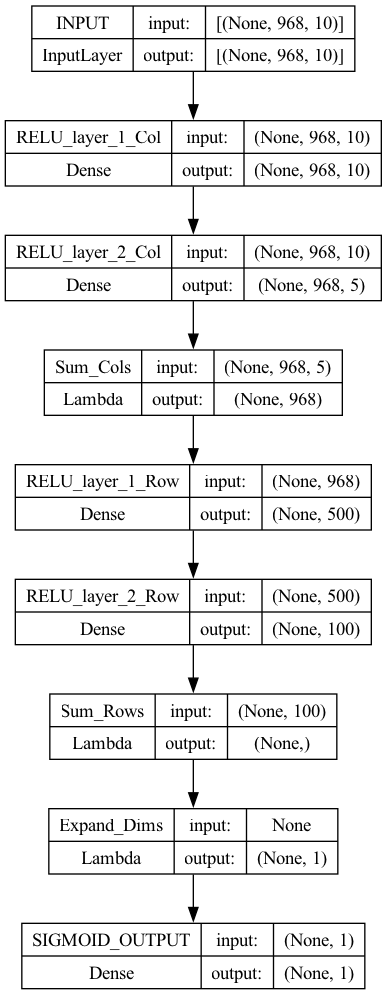

In [568]:
def get_matrix_model(row_count=968, col_count=10):
    input_matrix = Input(shape=(row_count, col_count),name = 'INPUT')
    
    # Processing each element (Embedding-like transformation with Dense)
    x = Dense(10, activation='relu', name = 'RELU_layer_1_Col')(input_matrix)  # Increase dimensionality
    x = Dense(5, activation='relu', name = 'RELU_layer_2_Col')(x)             
    
    # Row-wise Summation to make output invariant to column sorting
    row_sum = Lambda(lambda x: K.sum(x, axis=2), name = 'Sum_Cols')(x)  # Sum over columns (axis=2)
    
    # Another transformation on row-wise aggregated features
    row_encoded = Dense(500, activation='relu', name = 'RELU_layer_1_Row')(row_sum)
    row_encoded = Dense(100, activation='relu', name = 'RELU_layer_2_Row')(row_encoded)

    # Aggregating over rows since row order is preserved
    matrix_sum = Lambda(lambda x: K.sum(x, axis=1), name = 'Sum_Rows')(row_encoded)  # Sum over rows
    
    # Expand dims to match Dense layer input expectations
    matrix_sum_expanded = Lambda(lambda x: K.expand_dims(x, axis=-1), name = 'Expand_Dims')(matrix_sum)
    
    # Final output layer with sigmoid to constrain output between 0 and 1
    output = Dense(1, activation='sigmoid', name = 'SIGMOID_OUTPUT')(matrix_sum_expanded)
    
    # Define and compile model
    model = Model(inputs=input_matrix, outputs=output)
    optimizer = Adam(learning_rate=1e-4)  # Use legacy Adam optimizer
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    
    return model
    
model = get_matrix_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Display the SVG
display(Image(filename="model_plot.png"))

In [570]:
data_array = np.array(Mech_tokens)  # Shape should be (229, 50, 9680)

# Reshape each sample from length 9680 to shape (968, 10)
reshaped_data = data_array.reshape(229, 50, 968, 10)
targets = Labels

# Training loop with batch processing
epochs = 20
batch_size = 50  # The batch dimension in our data (we treat each batch of 50 as one step in model fit)
print('# NN:')
highest_ranked_valid_cumulative = []
y_pred_scores_cumulative = [] 
y_true_scores_cumulative = []
top_3_scores = []
for l in range(len(train_sets)):
    highest_ranked_valid = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    
    for index in train_sets[l]:
        X_train.append(reshaped_data[index])
        y_train.append(Labels[index])

    for index in test_sets[l]:
        X_test.append(reshaped_data[index])
        y_test.append(Labels[index])

    # Counters for 0s and 1s
    neg_count = 0
    pos_count = 0
    
    # Iterate through each row and element
    for row in y_train:
        for value in row:
            if value == 0:
                neg_count += 1
            elif value == 1:
                pos_count += 1
    
    # Avoid division by zero by ensuring a minimum count
    pos_weight = neg_count / pos_count  

    model = get_matrix_model()
    # Fit the model using each batch in X_train as an individual training step
    for epoch in range(epochs):
        for i in range(len(X_train)):
            # Extract a single batch for training
            X_batch = X_train[i]  # Shape (50, 968, 10)
            y_batch = np.full((batch_size,), y_train[i])  # Repeat the target to match batch size
            
            # Randomize the order in batch
            random_indices = np.random.permutation(len(X_batch))
            # Apply the same permutation to both arrays
            shuffled_X_batch = X_batch[random_indices]
            shuffled_y_batch = y_batch[random_indices]
            
            # Generate sample weights based on class frequency
            sample_weights = np.where(shuffled_y_batch  == 0, 1, pos_weight)
            #sample_weights = np.where(y_batch  == 0, 1, pos_weight)
            
            # Train on the batch with dynamically calculated sample weights
            model.train_on_batch(shuffled_X_batch, shuffled_y_batch,sample_weight=sample_weights)
            #model.train_on_batch(X_batch, y_batch,sample_weight=sample_weights)

    y_pred_scores = [] 
    y_true_scores = []
    for i in range(len(X_test)):
        y_pred = model.predict(X_test[i], verbose=0)
        true_y_pred = []
        for pred in y_pred:
            true_y_pred.append(pred[0]) 
            y_pred_scores.append(pred[0])
            y_pred_scores_cumulative.append(pred[0])
        
        for label in y_test[i]:
            y_true_scores.append(label)
            y_true_scores_cumulative.append(label)
    
        sorted_list_with_indexes = sorted(enumerate(true_y_pred), key=lambda x: x[1])[::-1]
        top_3_scores.append([each[1] for each in sorted_list_with_indexes[:3]])
        original_indexes = [item[0] for item in sorted_list_with_indexes]
        sorted_mechs = []
        for index in original_indexes:
            sorted_mechs.append(y_test[i][index])
        indexs = [index + 1 for index, value in enumerate(sorted_mechs) if value == 1]
        if indexs != []:
            highest_ranked_valid.append(indexs[0])
            highest_ranked_valid_cumulative.append(indexs[0])


    print('#',round((highest_ranked_valid.count(1)+highest_ranked_valid.count(2)+highest_ranked_valid.count(3))/len(highest_ranked_valid),3))
    precision_NN, recall_NN, thresholds_NN = precision_recall_curve(y_true_scores, y_pred_scores)
print('# Overall:')
print('#',round((highest_ranked_valid_cumulative.count(1)+highest_ranked_valid_cumulative.count(2)+highest_ranked_valid_cumulative.count(3))/len(highest_ranked_valid_cumulative),3))

#precision_NN, recall_NN, thresholds_NN = precision_recall_curve(y_true_scores_cumulative, y_pred_scores_cumulative)


# NN:
# 0.738
# 0.61
# 0.727
# 0.75
# 0.744
# Overall:
# 0.714


In [567]:
top_3_scores

[[0.46564928, 0.4257373, 0.40237835],
 [0.020226313, 0.013431212, 0.009163794],
 [0.53430927, 0.5323263, 0.5248922],
 [0.53521943, 0.53521943, 0.5345242],
 [0.53521943, 0.53521943, 0.53521943],
 [1.5007845e-06, 1.4932009e-06, 6.337122e-07],
 [0.53521943, 0.53521943, 0.5343905],
 [0.00013730278, 2.6047195e-05, 1.7997503e-05],
 [0.0011739329, 0.00085342745, 0.00045784286],
 [0.1429907, 0.004472639, 0.0028640698],
 [0.53521943, 0.53420043, 0.5325116],
 [0.5350294, 0.53342503, 0.5332069],
 [0.5270358, 0.51633394, 0.49231932],
 [0.53521943, 0.53521943, 0.5339014],
 [0.53210926, 0.5320031, 0.33743474],
 [0.53521943, 0.5236523, 0.4907026],
 [0.51267725, 0.45082608, 0.2839219],
 [0.53521943, 0.53198785, 0.5280844],
 [0.32363698, 0.3235949, 0.013833824],
 [0.53521943, 0.53521943, 0.53521943],
 [0.53521943, 0.5328941, 0.48398712],
 [0.533118, 0.4770567, 0.36566037],
 [0.5224963, 0.03668352, 0.02598813],
 [0.14127533, 0.12452728, 0.061720822],
 [0.27289137, 0.11192207, 0.10446891],
 [0.21226612, 

In [580]:
len(recall_NN[1:])

2245

In [579]:
len(thresholds_NN)

2245

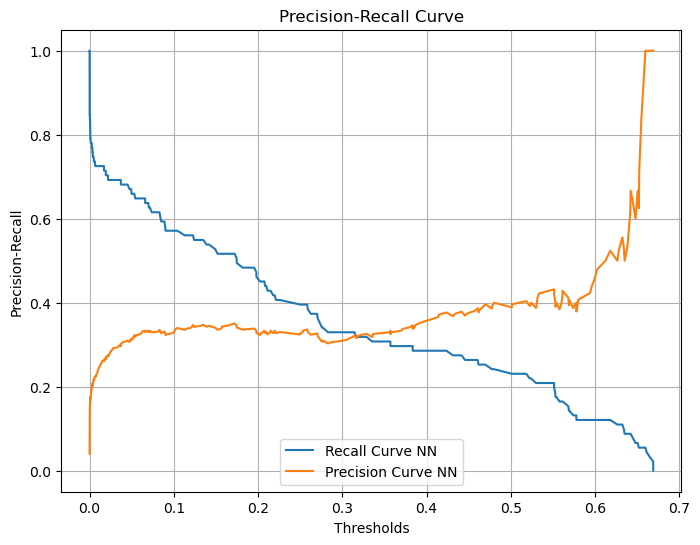

In [583]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(thresholds_NN, recall_NN[1:], label='Recall Curve NN')
plt.plot(thresholds_NN, precision_NN[1:], label='Precision Curve NN')
plt.xlabel('Thresholds')
plt.ylabel('Precision-Recall')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

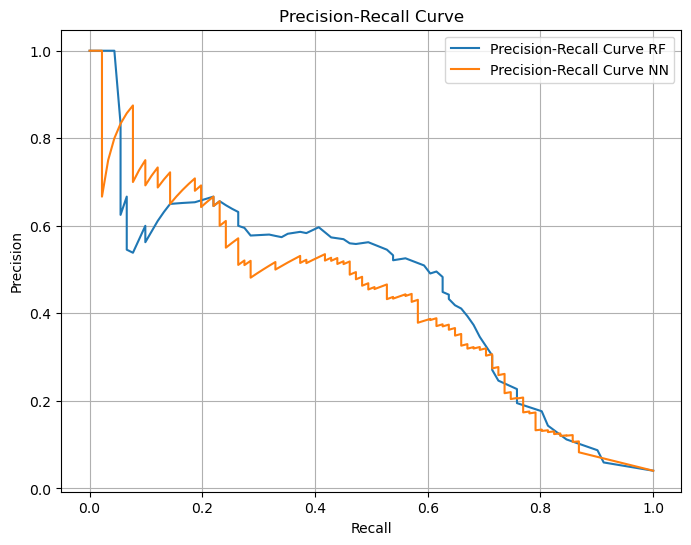

In [559]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(recall_RF, precision_RF, label='Precision-Recall Curve RF')
plt.plot(recall_NN, precision_NN, label='Precision-Recall Curve NN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#percentage in top 3:
# RUN 1

# RF:
# 0.738
# 0.7
# 0.659
# 0.651
# 0.7
# Overall:
# 0.689

# ML: 
# 0.81 
# 0.7
# 0.61
# 0.628
# 0.875
#Overall:
# 0.723

#RUN 2

# RF:
# 0.651
# 0.762
# 0.738
# 0.744
# 0.725
# Overall:
# 0.723

# ML:
# 0.698
# 0.786
# 0.714
# 0.846
# 0.775
# Overall:
# 0.762

#RUN 3

# RF:
# 0.667
# 0.614
# 0.682
# 0.732
# 0.658
# Overall:
# 0.67

# ML:
# 0.718
# 0.75
# 0.864
# 0.756
# 0.658
# Overall:
# 0.752

#RUN 4

# RF:
# 0.61
# 0.762
# 0.714
# 0.756
# 0.725
# Overall:
# 0.714

# ML:
# 0.732
# 0.786
# 0.786
# 0.805
# 0.675
# Overall:
# 0.757

#RUN 5

# RF:
# 0.725
# 0.625
# 0.738
# 0.651
# 0.732
# Overall:
# 0.694

# ML:
# 0.775
# 0.65
# 0.619
# 0.721
# 0.78
# Overall:
# 0.709

In [453]:

# lr 1e-4 relu 50, 30, 500, 100 
# total number tested: 206
# average highest ranking for valid mechs: 6.0
# percenage in top 3: 0.752
# number of first ranked valid mechs: 113
# number of second ranked valid mechs: 26
# number of third ranked valid mechs: 16

# lr 1e-4 relu 10, 5, 500, 100 
# total number tested: 206
# average highest ranking for valid mechs: 4.8
# percenage in top 3: 0.762
# number of first ranked valid mechs: 106
# number of second ranked valid mechs: 33
# number of third ranked valid mechs: 18

# lr 1e-4 tanh 10, 5, 500, 100 
# total number tested: 206
# average highest ranking for valid mechs: 17.3
# percenage in top 3: 0.189
# number of first ranked valid mechs: 18
# number of second ranked valid mechs: 13
# number of third ranked valid mechs: 8

# lr 1e-4 relu 10, 5, 500, 250 
# total number tested: 206
# average highest ranking for valid mechs: 4.7
# percenage in top 3: 0.694
# number of first ranked valid mechs: 108
# number of second ranked valid mechs: 26
# number of third ranked valid mechs: 9

# lr 1e-4 relu 10, 5, 500, 250, 50 
# total number tested: 206
# average highest ranking for valid mechs: 9.8
# percenage in top 3: 0.68
# number of first ranked valid mechs: 110
# number of second ranked valid mechs: 23
# number of third ranked valid mechs: 7

# lr 1e-4 relu 10, 5, 500, 100, 1 no sum 
# total number tested: 206
# average highest ranking for valid mechs: 13.2
# percenage in top 3: 0.65
# number of first ranked valid mechs: 95
# number of second ranked valid mechs: 31
# number of third ranked valid mechs: 8

In [529]:
n = 0

y_pred = model.predict(X_test[n], verbose=0)
y_true = y_test[n]

for i in range(len(y_pred)):
    print(y_true[i],(y_pred[i][0]))

1 0.9756501
0 0.8792339
0 0.90570813
0 0.43644917
0 0.4726723
0 0.43336824
0 0.46702847
0 0.5164498
0 0.73048383
0 0.5417322
0 0.43967542
0 0.44553384
0 0.45220608
0 0.43459642
0 0.4355071
0 0.574417
0 0.44253987
0 0.53604716
0 0.46604145
0 0.4466254
0 0.44179925
0 0.4349983
0 0.46445304
0 0.6742295
0 0.4371166
0 0.4339456
0 0.48790196
0 0.5547616
0 0.47303927
0 0.4393603
0 0.56759435
0 0.4922182
0 0.4588881
0 0.5216602
0 0.53466666
0 0.6190752
0 0.46908358
0 0.62443
0 0.550606
0 0.5671785
0 0.4343802
0 0.43336824
0 0.43722188
0 0.5087446
0 0.46800005
0 0.62619984
0 0.43336824
0 0.43336824
0 0.43336824
0 0.43336824


<BarContainer object of 50 artists>

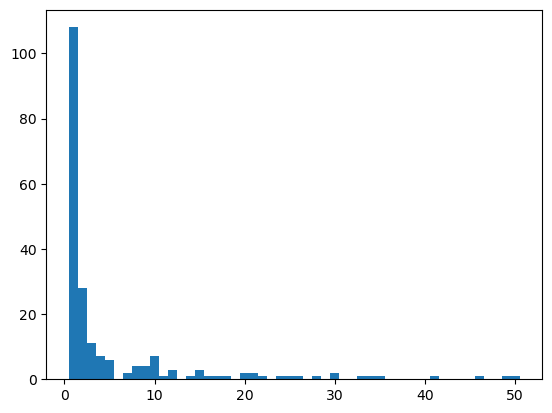

In [571]:
highest_ranked_valid_count = []
for i in range(50):
    highest_ranked_valid_count.append(highest_ranked_valid_cumulative.count(i+1))


plt.bar(range(1,51), highest_ranked_valid_count, width=1.0)


In [ ]:
 true_y_pred = []
        for pred in y_pred:
            true_y_pred.append(pred[1]) 
        
        sorted_list_with_indexes = sorted(enumerate(true_y_pred), key=lambda x: x[1])[::-1]
        original_indexes = [item[0] for item in sorted_list_with_indexes]
        sorted_mechs = []
        for index in original_indexes:
            sorted_mechs.append(Labels[i][index])
        indexs = [index + 1 for index, value in enumerate(sorted_mechs) if value == 1]
        if indexs == []:
            highest_ranked_valid.append(0)
        else:
            highest_ranked_valid.append(indexs[0])

In [151]:
prediction = model.predict(X_test[10])
prediction[0][0]

2/2 [==============================] - 0s 2ms/step


7.4323366e-06

In [141]:
y_test[10]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [738]:
sorted_list_with_indexes = sorted(enumerate(highest_ranked_valid), key=lambda x: x[1])[::-1]
original_indexes = [item[0] for item in sorted_list_with_indexes]
sort = []
for index in original_indexes:
    sort.append(random_indexs[index])

for i in range(len(sort)):
    print(Unique_Fixed_Rxns_List[indexes[test_sets[sort[i]][0]]], indexes[test_sets[sort[i]][0]],sorted_list_with_indexes[i][1])


205_1 100 50
339_1&570_1&801_1 149 50
182_1&182_2&182_3 85 50
202_1 98 47
613_1 182 47
2_1&2_2&15_1&210_1&257_1&258_1&258_2&1001_1 0 39
39_1&807_1 21 22
546_1 173 21
754_1 209 18
95_1&308_1&736_1&842_1&880_1 61 16
50_1&50_2 28 15
642_1&833_1 190 15
319_1 141 15
760_1 210 15
594_1 180 15
706_1 203 14
740_1 207 12
661_1 196 9
76_1 47 8
793_1 215 6
566_1 176 6
180_1 83 6
524_1 170 5
843_1 221 5
80_1 51 5
350_1&691_1 154 4
451_1 160 4
645_1 192 4
1005_1 243 4
186_1 88 4
343_1 151 4
569_1 177 4
233_1 113 3
100_1 65 3
954_1&954_2 233 3
811_1 218 3
488_1&488_2&680_1 165 3
93_1&93_2&93_3 60 3
25_1 15 3
353_1 155 3
61_1 37 3
224_1&344_1 109 3
151_1&209_1&365_1&588_1&615_1&654_1&663_1&696_1 71 2
8_1 4 2
192_1&192_2 89 2
463_1&502_1&960_1&961_1&963_1 161 2
35_1&58_1&282_1&592_1&653_1&757_1&778_1 18 2
579_1 179 2
346_1 152 2
86_1 55 2
781_1 213 2
328_1 145 2
36_1 19 2
6_1 2 2
636_1 189 2
236_1&236_2 115 2
517_1 168 2
312_1&526_1&527_1&584_1&593_1&775_1&785_1 136 2
87_1&87_2 56 2
485_1 164 2
315_1 

In [739]:
mech_vectors[100]

[['649_1_1', '222_1_6&577_1_2&754_1_2'],
 ['203_2_1&764_1_1&774_2_1&819_1_1',
  '205_1_2&244_1_2&368_2_6&368_4_3',
  '222_1_6&577_1_2&754_1_2'],
 ['203_2_1&764_1_1&774_2_1&819_1_1', '546_1_2', '91_1_3'],
 ['91_1_1', '340_1_2', '205_1_1', '91_1_3'],
 ['546_1_2', '649_1_1', '368_2_1', '91_1_3'],
 ['203_2_1&764_1_1&774_2_1&819_1_1',
  '368_2_2',
  '368_1_4',
  '222_1_6&577_1_2&754_1_2'],
 ['10_1_3&28_1_1&42_1_3&158_1_1&160_1_2&324_2_4&832_1_1',
  '91_1_1',
  '203_2_1&764_1_1&774_2_1&819_1_1',
  '91_1_3'],
 ['27_2_2&35_1_2&48_1_2&58_1_2&86_1_2&282_1_3&757_1_2&770_1_2&802_1_2',
  '205_1_1',
  '546_1_2',
  '91_1_3'],
 ['649_1_1', '205_1_1', '580_1_3&764_1_2&807_1_3', '826_1_2'],
 ['580_1_1',
  '580_1_2',
  '205_1_2&244_1_2&368_2_6&368_4_3',
  '222_1_6&577_1_2&754_1_2'],
 ['546_1_2', '580_1_1', '580_1_2', '91_1_3'],
 ['7_3_1&8_1_1&76_1_1', '649_1_1', '205_1_1', '356_1_2'],
 ['368_4_2', '546_1_2', '91_1_3', '649_1_1', '368_4_1'],
 ['580_1_1', '580_1_2', '368_2_2', '368_1_4', '222_1_6&577_1_2&7

In [741]:
labels[100]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [740]:
j = 205
mech  = ['649_1_1', '222_1_6&577_1_2&754_1_2']

reaction_string = rxn_string[j-1] 

reactants = reaction_string.split('>>')[0]
products = reaction_string.split('>>')[1]

reactant_moieties = {}
for reactant in reactants.split('.'):
    reactant_moieties = add_dicts(reactant_moieties,count_substructures(radius,Chem.MolFromSmiles(reactant)))
reactant_df = pd.DataFrame.from_dict(reactant_moieties, orient='index')
reactant_df.columns = ['Reactants']

product_moieties = {}
for product in products.split('.'):
    product_moieties = add_dicts(product_moieties,count_substructures(radius,Chem.MolFromSmiles(product)))
    
product_df = pd.DataFrame.from_dict(product_moieties, orient='index')
product_df.columns = ['Products']

true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
Mechanism  = pd.DataFrame.from_dict(true_rxn, orient='index')
Mechanism.columns = ['RXN']

Mechanism = pd.concat([Mechanism, reactant_df], axis=1)
Mechanism = Mechanism.fillna(0).astype(int)

for rule in mech:
    df = pd.DataFrame.from_dict(Unique_Rules[Unique_Rules[rule] != 0][rule].to_dict(), orient='index')
    df.columns = [rule]
    Mechanism = pd.concat([Mechanism, df], axis=1)
    Mechanism = Mechanism.fillna(0).astype(int)

Mechanism = pd.concat([Mechanism, product_df], axis=1)
Mechanism = Mechanism.fillna(0).astype(int)

pd.options.display.max_rows = len(Mechanism)  

Mechanism


,RXN,Reactants,649_1_1,222_1_6&577_1_2&754_1_2,Products
COP,1,0,1,0,1
COC,-1,2,-1,0,1
CO,1,5,1,0,6
OP,-1,1,0,-1,0
O=P,0,1,0,0,1
O=P([O-])([O-])O,0,1,-1,1,1
[O-]P,0,2,-1,1,2
CC(O)O,0,1,0,0,1
CC(C)O,0,4,0,0,4
CCO,0,1,0,0,1


In [730]:
l = 104
Mech_tokens_train = []
Labels_train = []
for index in train_sets[l]:
    Mech_tokens_train = Mech_tokens_train + Mech_tokens[index]
    Labels_train = Labels_train + Labels[index]


total = Labels_train.count(0) + round(Labels_train.count(0)/Labels_train.count(1))*Labels_train.count(1)
total_inv = 1/total
weight = []
factor = round(Labels_train.count(0)/Labels_train.count(1))/total
for val in Labels_train:
    if val == 0:
        weight.append(total_inv)
    else:
        weight.append(factor)

rf = RandomForestClassifier(random_state=42,n_estimators = 50)
rf.fit(Mech_tokens_train,Labels_train,sample_weight = weight)

for i in test_sets[l]:
    y_pred = rf.predict_proba(Mech_tokens[i])
    true_y_pred = []
    for pred in y_pred:
        true_y_pred.append(pred[1]) 
    
    sorted_list_with_indexes = sorted(enumerate(true_y_pred), key=lambda x: x[1])[::-1]
    original_indexes = [item[0] for item in sorted_list_with_indexes]
    sorted_mechs = []
    for index in original_indexes:
        sorted_mechs.append(Labels[i][index])
        
true_y_pred

[0.2,
 0.0,
 0.0,
 0.0,
 0.06,
 0.0,
 0.02,
 0.0,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.12,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02,
 0.0,
 0.02,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02]

In [293]:
test_fraction = 0.2
if test_fraction != 0:
    X_train, X_test, y_train, y_test = train_test_split(Mech_tokens, label_vector, test_size = test_fraction)
    rf = RandomForestClassifier(random_state=42,n_estimators = 50)
    rf.fit(X_train, y_train,sample_weight = 1)
else:
    


In [294]:
y_pred = rf.predict_proba(X_test)

true_y_pred = []
for pred in y_pred:
    true_y_pred.append(pred[1]) 

sorted_list_with_indexes = sorted(enumerate(true_y_pred), key=lambda x: x[1])
original_indexes = [item[0] for item in sorted_list_with_indexes][::-1]
sorted_mechs = []
for index in original_indexes:
    sorted_mechs.append(y_test[index])

print(len(sorted_mechs))    
scores = [index + 1 for index, value in enumerate(sorted_mechs) if value == 1]
adjusted_score = []
for index in range(len(scores)):
    adjusted_score.append(scores[index] - index -1)

sum(adjusted_score)/len(adjusted_score)


4045


574.0428571428571

In [298]:
scores

[2,
 4,
 9,
 14,
 18,
 19,
 29,
 38,
 39,
 41,
 44,
 45,
 49,
 52,
 54,
 57,
 58,
 63,
 66,
 69,
 80,
 84,
 86,
 88,
 90,
 93,
 96,
 100,
 106,
 113,
 125,
 126,
 132,
 136,
 162,
 170,
 187,
 213,
 236,
 259,
 292,
 300,
 364,
 397,
 423,
 430,
 466,
 487,
 488,
 523,
 594,
 622,
 639,
 654,
 758,
 822,
 969,
 1058,
 1091,
 1207,
 1731,
 1886,
 1977,
 2012,
 2225,
 2475,
 3233,
 3555,
 3756,
 3782]

In [295]:
ones_indexs = []
score = []
for l in tqdm(range(len(mech_vectors))):
    Mech_token = []
    for m in range(len(mech_vectors[l])):  
        mech = []
        for i in range(largest_mech):
            if i > len(mech_vectors[l][m]) - 1:
                mech = mech + [0 for _ in range(num_moieties)]
            else:
                mech = mech + Unique_Rules[mech_vectors[l][m][i]].values.tolist()
        Mech_token.append(mech)
        
    y_pred = rf.predict_proba(Mech_token)
    true_y_pred = []
    for pred in y_pred:
        true_y_pred.append(pred[1]) 
    
    sorted_list_with_indexes = sorted(enumerate(true_y_pred), key=lambda x: x[1])
    original_indexes = [item[0] for item in sorted_list_with_indexes][::-1]
    sorted_mechs = []
    for index in original_indexes:
        sorted_mechs.append(labels[l][index])
    indexs = [index + 1 for index, value in enumerate(sorted_mechs) if value == 1]
    if indexs != []:
        ones_indexs.append(indexs)
        score.append(len(indexs)/max(indexs))


sum(score)/len(score)

100%|█████████████████████████████████████████| 223/223 [00:11<00:00, 20.01it/s]


0.8903824307822629

In [296]:
adjusted_scores = []
for lists in ones_indexs:
    adjusted_score = []
    for index in range(len(lists)):
        adjusted_score.append(lists[index] - index -1)
    adjusted_scores.append(sum(adjusted_score)/len(adjusted_score))

sum(adjusted_scores)/len(adjusted_scores)

2.903825321597833

In [299]:
ones_indexs

[[1, 2, 3],
 [1, 2, 3, 4, 5, 6],
 [1],
 [1, 2, 3],
 [1],
 [1],
 [1],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 21, 24, 33, 92],
 [1],
 [4],
 [1],
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 [1],
 [1, 2, 3],
 [1],
 [1],
 [1, 98],
 [1, 98],
 [1, 2, 3, 5],
 [1],
 [1],
 [1, 2],
 [1],
 [1, 2],
 [1],
 [1],
 [1],
 [1, 3],
 [1],
 [1, 3],
 [1, 2],
 [1, 2, 4],
 [1, 2],
 [1],
 [1],
 [1],
 [1, 2],
 [1],
 [1, 2, 3],
 [1, 2],
 [1],
 [2],
 [1],
 [1],
 [1],
 [1],
 [1],
 [9],
 [2, 100],
 [100],
 [8],
 [1, 2, 3],
 [1],
 [1, 2, 3],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1, 2],
 [1],
 [1, 2],
 [1],
 [1],
 [1],
 [1],
 [1, 2],
 [1, 2, 4],
 [3],
 [1],
 [1],
 [1, 2, 3],
 [1, 2],
 [1],
 [1],
 [1],
 [5],
 [1],
 [1],
 [1],
 [3],
 [1],
 [1],
 [1, 2],
 [1],
 [1, 2],
 [1, 2],
 [1],
 [1, 12],
 [1, 2],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [3],
 [1, 13, 79],
 [1, 2],
 [1, 2, 3],
 [1],
 [1, 2, 3, 5, 6],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1],
 [1, 95],
 [1],
 [1, 2],
 [1],
 [1],
 [1],
 [1],
 

In [256]:
param_grid = {'n_estimators': [55,65]}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = GridSearchCV(rf, param_grid =  param_grid)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [55, 65]})

In [257]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'n_estimators': 55}


In [ ]:
num_moieties = len(Unique_Rules[mechanism[0]])
mech = []
for i in range(20):
    if i > len(mechanism) - 1:
        mech = mech + [0 for _ in range(num_moieties)]
    else:
        mech = mech + Unique_Rules[mechanism[0]].values.tolist()

In [837]:
entries = [['5','169','173','176','238','608','609','688','723','798','821','821'], ['176','821']]
common_entries = set(entries[0])
for lst in entries:
    common_entries.intersection_update(lst)
J = ['821']
if common_entries.intersection(set(J)) != set():
    print(J[0])
common_entries

821


{'176', '821'}

In [823]:
num_moieties = len(Unique_Rules[solutions[0][0]])
mech = []
for i in range(11):
    if i > len(solutions[0]) - 1:
        mech = mech + [0 for _ in range(num_moieties)]
    else:
        mech = mech + Unique_Rules[solutions[0][0]].values.tolist()
len(mech)

553.0

In [101]:
num_moieties = len(Unique_Rules[mech_vectors[0][0]])  
mech_lengths = []
for solutions in mech_vectors:
    for mechanism in solutions:
        mech_lengths.append(len(mechanism))
largest_mech = max(mech_lengths)
for l in range(len(mech_vectors)):
    Mech_tokens = []
    for m in range(len(mech_vectors[l])):  
        mech = []
        for i in range(largest_mech):
            if i > len(mech_vectors[l][m]) - 1:
                mech = mech + [0 for _ in range(num_moieties)]
            else:
                mech = mech + Unique_Rules[mech_vectors[l][m][i]].values.tolist()
        Mech_tokens.append(mech)
        
    X_train, X_test, y_train, y_test = train_test_split(Mech_tokens, labels[l], test_size=0.2)
    
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train,sample_weight = 1)
    y_pred = rf.predict(X_test)
    print(accuracy_score(y_test, y_pred))

1.0
0.9
1.0
1.0
1.0
0.95
1.0
0.85
1.0
1.0


ValueError: With n_samples=1, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [55]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Step 2: Train the model using provided labeled matrices
class MatrixScorePredictor:
    def __init__(self):
        # Initialize the model (Multi-layer Perceptron as an example)
        self.model = MLPClassifier(hidden_layer_sizes=(64, 32, 16), max_iter=500)

    def fit(self, X, y): 
        # Fit the model
        self.model.fit(X, y)

    def predict(self, X):
        # Predict scores (between 0 and 1)
        return self.model.predict_proba(X)[:, 1]  # Probability for class 1

    def save_model(self, filename):
        # Save the model to a file
        joblib.dump(self.model, filename)
        print(f"Model saved to {filename}")

    def load_model(self, filename):
        # Load the model from a file
        self.model = joblib.load(filename)
        print(f"Model loaded from {filename}")


In [113]:
num_moieties = len(Unique_Rules[mech_vectors[0][0]])  
mech_lengths = []
for solutions in mech_vectors:
    for mechanism in solutions:
        mech_lengths.append(len(mechanism))
largest_mech = max(mech_lengths)
for l in tqdm(range(len(mech_vectors))):
    Mech_tokens = []
    for m in range(len(mech_vectors[l])):  
        mech = []
        for i in range(largest_mech):
            if i > len(mech_vectors[l][m]) - 1:
                mech = mech + [0 for _ in range(num_moieties)]
            else:
                mech = mech + Unique_Rules[mech_vectors[l][m][i]].values.tolist()
        Mech_tokens.append(mech)
        
    predictor = MatrixScorePredictor()
    predictor.fit(Mech_tokens, labels[l])

# Save the model after training
predictor.save_model('matrix_score_predictor.pkl')


100%|███████████████████████████████████████| 223/223 [1:05:54<00:00, 17.73s/it]


In [79]:
largest_mech = 16
num_moieties = len(Unique_Rules[mech_vectors[0][0]])  
Mech_tokens = []
for m in range(len(mech_vectors[0])):  
    mech = []
    for i in range(largest_mech):
        if i > len(mech_vectors[0][m]) - 1:
            mech = mech + [0 for _ in range(num_moieties)]
        else:
            mech = mech + Unique_Rules[mech_vectors[0][m][i]].values.tolist()
    Mech_tokens.append(mech)

In [80]:
mech_vectors

[[['59_1_2', '85_1_4', '112_1_1', '312_1_1'],
  ['84_1_4', '84_1_5', '112_1_1', '312_1_1'],
  ['84_1_4', '84_1_5', '112_1_1', '593_1_3&775_1_2', '775_1_1&889_1_1'],
  ['59_1_2', '85_1_4', '112_1_1', '593_1_3&775_1_2', '775_1_1&889_1_1'],
  ['85_1_4',
   '112_1_1',
   '164_1_2&300_1_2&564_1_2&727_1_2&812_1_2',
   '228_2_2',
   '312_1_1'],
  ['84_1_4', '84_1_5', '112_1_1', '584_1_1', '584_1_2&621_1_3'],
  ['59_1_2',
   '85_1_4',
   '112_1_1',
   '188_1_1&188_2_1&228_1_1&228_2_1&557_1_1&557_2_1',
   '255_1_1&604_1_3&604_1_6&604_1_9&691_1_3'],
  ['22_1_4&96_1_4&216_1_3&317_1_5&329_1_2&336_1_3&526_1_2&527_1_2&785_1_2&843_1_2&984_1_3',
   '59_1_1&526_1_1&527_1_1&785_1_1',
   '84_1_4',
   '84_1_5',
   '112_1_1'],
  ['22_1_4&96_1_4&216_1_3&317_1_5&329_1_2&336_1_3&526_1_2&527_1_2&785_1_2&843_1_2&984_1_3',
   '59_1_1&526_1_1&527_1_1&785_1_1',
   '59_1_2',
   '85_1_4',
   '112_1_1'],
  ['7_1_1&7_2_1&21_1_1',
   '19_1_1&36_1_3&116_1_3&171_1_3&223_1_8&332_1_2&339_1_2&345_1_5&365_1_2&525_1_6&525_2_4

In [81]:
len(Mech_tokens)

100

In [82]:

#load the model and use it for prediction
new_predictor = MatrixScorePredictor()
new_predictor.load_model('matrix_score_predictor.pkl')

# Predict with the loaded model on a new set of matrices
predicted_scores = new_predictor.predict(Mech_tokens)
print("Predicted scores:", predicted_scores)

Model loaded from matrix_score_predictor.pkl
Predicted scores: [1.45885267e-01 1.68504642e-01 6.56083170e-02 3.40189159e-02
 1.99344495e-02 1.75323770e-01 2.16315855e-01 3.84800452e-01
 4.04378222e-01 2.88309497e-02 1.44512135e-01 2.28065349e-04
 7.47799187e-02 2.44296510e-01 1.13579697e-01 7.21078775e-02
 1.42869638e-01 7.47866228e-03 6.26819759e-02 6.94479707e-02
 3.94673871e-02 1.29145111e-03 5.55082945e-02 7.49597521e-03
 1.97391291e-01 2.40134622e-02 8.26942811e-03 3.27344934e-02
 1.00262512e-04 3.30791331e-02 2.39526069e-02 8.36285493e-02
 1.89792401e-03 1.78442328e-02 2.53592531e-01 2.99879824e-01
 3.04385569e-03 2.14844794e-01 2.90615339e-03 1.70041894e-03
 7.50865320e-02 4.81034127e-03 3.93144727e-02 1.28102720e-01
 1.77428299e-01 1.36794715e-02 1.25649515e-01 5.51138166e-02
 2.59160642e-02 6.06129374e-02 3.75886227e-02 3.20692667e-01
 1.53861624e-01 2.76058247e-01 1.99981884e-01 3.72951508e-02
 7.81234843e-02 3.21906333e-03 1.66534201e-01 2.85463139e-02
 2.14430177e-02 2.5232

In [84]:


difference = [abs(a - b) for a, b in zip(labels[0], predicted_scores)]
sum(difference)/len(difference)

0.1130956799693092

In [74]:
max(predicted_scores)

0.4291413060172171

In [83]:
labels[0]

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0]

In [718]:
mech_rxns = []
for solution in solutions:
    rxn_rules = []
    for rules in solution:
        rxn_rules.append(moiety_dict_to_reaction_smiles(Unique_Rules[Unique_Rules[rules] != 0][rules].to_dict()))
    mech_rxns.append(rxn_rules)
mech_rxns     

[['C=O.CC(N)=O.O>>CO.CO.CC(N)(O)O', 'CO.CNC.CC(N)(O)O>>CC(=O)O.C=O.CN'],
 ['CO.CC(N)([O-])O.CNC>>CC(=O)[O-].C=O.CN',
  'CC(=O)[O-].C=O.CC(N)=O.O>>CC(=O)O.CO.CO.CC(N)([O-])O'],
 ['CC(=O)[O-].C=O.CC(N)=O>>CC(=O)O.CC(N)([O-])O.COC',
  'COC.O>>CO.CO',
  'CO.CC(N)([O-])O.CNC>>CC(=O)[O-].C=O.CN'],
 ['C=O.CC(N)=O.[OH-]>>CO.C[O-].CC(N)([O-])O',
  'CC(=O)[O-].C[O-].O>>CC(=O)O.CO.[OH-]',
  'CO.CC(N)([O-])O.CNC>>CC(=O)[O-].C=O.CN'],
 ['CC(=O)[O-].C=O.CC(N)=O.O>>CC(=O)O.CO.CO.CC(N)([O-])O',
  'CO.CNC.CC(N)(O)O>>CC(=O)O.C=O.CN',
  'CC(=O)O.CC(N)([O-])O>>CC(=O)[O-].CC(N)(O)O'],
 ['C=O.CC(N)=O.CC[O-]>>CC(N)([O-])O.COC.CCO',
  'COC.O>>CO.CO',
  'CO.CC(N)([O-])O.CNC.CCO>>CC(=O)O.C=O.CC[O-].CN'],
 ['CC(=O)O.CC[O-]>>CC(=O)[O-].CCO',
  'CC(=O)[O-].C=O.CC(N)=O.O>>CC(=O)O.CO.CO.CC(N)([O-])O',
  'CO.CC(N)([O-])O.CNC.CCO>>CC(=O)O.C=O.CC[O-].CN'],
 ['C=O.CC(N)=O.CC[O-]>>CC(N)([O-])O.COC.CCO',
  'COC.O>>CO.CO',
  'CC(=O)[O-].CCO>>CC(=O)O.CC[O-]',
  'CO.CC(N)([O-])O.CNC>>CC(=O)[O-].C=O.CN'],
 ['C=O.CC(N)=O.O.CCN

In [ ]:
    for m in range(len(mechanisms_2)):
        new_integer_cut_rules = integer_cut_rules + mechanisms_2[m]
        length = len(new_integer_cut_rules) - 1
        lp_prob += (
            pulp.lpSum([y_rule[r] for r in new_integer_cut_rules]) <= length,
            "integer_cut_" + str(sol_num) + "_" + str(m) + "_2",
        )
    for m in range(len(mechanisms_3)):
        new_integer_cut_rules = integer_cut_rules + mechanisms_3[m]
        length = len(new_integer_cut_rules) - 1
        lp_prob += (
            pulp.lpSum([y_rule[r] for r in new_integer_cut_rules]) <= length,
            "integer_cut_" + str(sol_num) + "_" + str(m) + "_3",
        )

In [600]:
Unique_Fixed_Rxns.columns.tolist()


['2_1&2_2&15_1&210_1&257_1&258_1&258_2&1001_1',
 '5_1&168_1&169_1&173_1&175_1&177_1&238_1&241_1&266_1&396_1&595_1&608_1&609_1&624_1&635_1&676_1&679_1&688_1&718_1&723_1&724_1&731_1&746_1&747_1&789_1&798_1&805_1&806_1&814_1&815_1&816_1&818_1&820_1&821_1&821_2&821_3&830_1&917_1&964_1',
 '6_1',
 '7_1&7_2&7_3',
 '8_1',
 '9_1',
 '10_1',
 '11_1&27_1&27_2&28_1&163_1&163_2&164_1&321_1&338_1&530_1&564_1&565_1&577_1&634_1&693_1&727_1&794_1&810_1&812_1&836_1&838_1&839_1&856_1&904_1&955_1',
 '12_1',
 '16_1',
 '17_1',
 '19_1&83_1&94_1&203_1&203_2&218_1&285_1&337_1&397_1&518_1&519_1&520_1&528_1&529_1&548_1&559_1&560_1&561_1&580_1&616_1&644_1&650_1&658_1&667_1&681_1&705_1&733_1&748_1&748_2&755_1&764_1&774_1&774_2&817_1&819_1&827_1&828_1&829_1&829_2&829_3&831_1&835_1&847_1&866_1&899_2&922_1&976_1',
 '21_1',
 '22_1&525_1&525_2',
 '23_1',
 '25_1',
 '31_1&31_2',
 '32_1&359_1&359_2',
 '35_1&58_1&592_1&653_1&757_1&778_1',
 '36_1',
 '38_1',
 '39_1&807_1',
 '40_1',
 '44_1&300_1',
 '46_1',
 '47_1',
 '48_1&802_

In [604]:
Unique_Fixed_Rxns_List = Unique_Fixed_Rxns.columns.tolist()
for l in range(len(Unique_Fixed_Rxns_List)):
    J = Unique_Fixed_Rxns_List[l].split("&")
    j = int(J[0].split("_")[0])
    W = 20 # Max steps allowed 
    iterations = 30 # Max integer cuts
    
    reaction_string = rxn_string[j-1] # Can input any reaction string here
    true_rxn = reaction_string_to_moiety_change_dict(reaction_string,radius)
    if true_rxn == {}:
        continue 
    else:
        T_EX = pd.DataFrame(true_rxn, index=['True Reaction'])
        T_EX = T_EX.T
        
        # Create a new DataFrame with one column and named rows from the vector of strings
        C_m = {}
        # Populate the dictionary with values from T_EX DataFrame
        for index in moiety_index:
            if index in T_EX.index:
                C_m[index] = T_EX.loc[index, 'True Reaction']
            else:
                C_m[index] = 0.0
        
        
        ###### variables ######
        y_rule = pulp.LpVariable.dicts("y", rules_index, lowBound=0, upBound=1, cat="Binary") 
        
        # create MILP problem
        lp_prob = pulp.LpProblem("MechFind", pulp.LpMinimize)
        
        ####### objective function ####
        lp_prob += pulp.lpSum([[T_abs[m][r] * y_rule[r] for r in rules_index] for m in moiety_index])
        #lp_prob += pulp.lpSum([y_rule[r] for r in rules_index])
        
        ####### constraints ####
        # constraint 1: moiety change balance
        for m in moiety_index:
            lp_prob += (
                pulp.lpSum([T[m][r] * y_rule[r] for r in rules_index ])
                == [C_m[m]],
                "moiety_balance_" + str(moiety_index.index(m))
            )
        # constraint 2: customized constraints
        # the number of steps of the pathway
        lp_prob += pulp.lpSum([y_rule[r] for r in rules_index]) <= W
        
        for sol_num in range(1, iterations + 1):
            if sol_num == 30:
                print(J[0],'30+')
                break
            
            integer_cut_rules = []
            lp_prob.writeLP('./test.lp')
            lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))
        
            if pulp.LpStatus[lp_prob.status] != 'Optimal':
                print(J[0],'mech not found')
                break
            mechanism = []
            for r in rules_index:
                if y_rule[r].varValue != 0:
                    integer_cut_rules.append(r)
                    mechanism.append(Unique_Rules.columns.tolist()[r])
            entries = []
            for r in range(len(mechanism)):
                steps = mechanism[r].split("&")
                e_m = []
                for s in range(len(steps)):
                    entry = steps[s].split("_")[0]
                    mech = steps[s].split("_")[1]
                    e_m.append(entry + '_' + mech)
                entries.append(e_m)
            
            common_entries = set(entries[0])
            for lst in entries[1:]:
                common_entries.intersection_update(lst)
            if common_entries.intersection(set(J)) != set():
                print(J[0],sol_num)
                break
        
            length = len(integer_cut_rules) - 1
            lp_prob += (
                pulp.lpSum([y_rule[r] for r in integer_cut_rules]) <= length,
                "integer_cut_" + str(sol_num),
            )
            for m in range(len(mechanisms_2)):
                new_integer_cut_rules = integer_cut_rules + mechanisms_2[m]
                length = len(new_integer_cut_rules) - 1
                lp_prob += (
                    pulp.lpSum([y_rule[r] for r in new_integer_cut_rules]) <= length,
                    "integer_cut_" + str(sol_num) + "_" + str(m) + "_2",
                )
            for m in range(len(mechanisms_3)):
                new_integer_cut_rules = integer_cut_rules + mechanisms_3[m]
                length = len(new_integer_cut_rules) - 1
                lp_prob += (
                    pulp.lpSum([y_rule[r] for r in new_integer_cut_rules]) <= length,
                    "integer_cut_" + str(sol_num) + "_" + str(m) + "_3",
                )



2_1 1
5_1 1
6_1 30+
7_1 2
8_1 1
9_1 1
10_1 8
11_1 1
12_1 1
16_1 3
17_1 1
19_1 1
21_1 12
22_1 3
23_1 1
25_1 1
31_1 2
32_1 2
35_1 1
36_1 1
38_1 1
39_1 1
40_1 1
44_1 1
46_1 1
47_1 2
48_1 1
50_1 1
51_1 1
52_1 1
54_1 1
56_1 1
57_1 1
59_1 1
60_1 30+
61_1 7
67_1 10
69_1 16
70_1 1
71_2 1
72_1 2
73_1 12
74_1 2
77_1 1
79_1 1
80_1 1
81_1 1
84_1 30+
85_1 6
87_1 2
90_1 1
91_1 1
93_1 5
96_1 1
97_1 1
98_1 1
112_1 1
116_1 1
128_1 1
149_1 2
151_1 1
154_1 1
155_1 1
157_1 30+
158_1 2
162_1 30+
166_2 2
171_1 2
172_1 2
176_1 3
178_1 2
180_1 1
181_1 1
182_4 1
184_1 1
186_1 30+
192_1 1
193_1 1
198_1 2
199_1 1
201_1 2
204_1 1
205_1 3
207_1 10
211_1 30+
215_1 30+
216_1 6
217_1 1
220_1 3
221_1 1
223_1 4
224_1 1
227_2 1
228_1 30+
235_1 2
248_1 1
255_1 2
256_1 1
269_1 1
271_2 1
272_1 3
280_1 30+
287_1 1
289_2 30+
301_1 2
305_1 2
307_1 30+
308_1 20
311_1 6
312_1 1
313_1 1
314_1 30+
315_1 1
317_1 30+
319_1 30+
320_1 1
324_1 2
326_1 1
327_1 1
328_1 1
332_1 1
333_1 30+
336_1 1
339_1 1
343_1 1
345_1 24
346_1 1
348_1 1

In [485]:
reaction_string_to_moiety_change_dict(rxn_string[0],radius)

{}

In [486]:
mechanism  = [
'151_1_1&201_1_1&223_2_1' ,
]


{'151_1', '201_1', '223_2'}

In [461]:
rule = '2_1_3&27_1_2&488_1_4&546_1_3'
moiety_dict_to_reaction_smiles(Unique_Rules[Unique_Rules[rule] != 0][rule].to_dict())

'CC(=O)O.CC[O-]>>CC(=O)[O-].CCO'

In [408]:
entry_strings[307][0]

['CCC(=O)[O-].CCc1c[nH+]c[nH]1.OC1COC(O)C(O)C1O>>CCC(=O)O.CCc1cnc[nH]1.O=CC(O)C(O)C(O)CO',
 'CCC(=O)[O-].O>>CCC(=O)O.[OH-]',
 'O=CC(O)C(O)C(O)CO>>O=C(CO)C(O)C(O)CO',
 'CCC(=O)O.CCc1cnc[nH]1.O=C(CO)C(O)C(O)CO>>CCC(=O)[O-].CCc1c[nH+]c[nH]1.OCC1(O)OCC(O)C1O',
 'CCC(=O)O.[OH-]>>CCC(=O)[O-].O']

In [409]:
reaction_atom_and_e_balance('O=CC(O)C(O)C(O)CO>>O=C(CO)C(O)C(O)CO')

({},
 [{'O': -5, 'e': -80, 'C': -5, 'H': -10}, {'O': 5, 'e': 80, 'C': 5, 'H': 10}],
 ['O=CC(O)C(O)C(O)CO', 'O=C(CO)C(O)C(O)CO'])

In [268]:
pd.DataFrame.from_dict(count_substructures(1, Chem.MolFromSmiles('OCC1OC(O)C(O)C(O)C1O')), orient='index')

,0
CO,5
CCO,1
CC(C)O,4
COC,1
CC(O)O,1


In [280]:
rxn_string[51]

'O=CC(O)COP(=O)([O-])[O-].O=C(CO)COP(=O)([O-])[O-]>>O=P([O-])([O-])OCC1OC(O)(COP(=O)([O-])[O-])C(O)C1O'

In [143]:
soln_file = 'solution.txt'
if os.path.exists('solution.txt'):
    os.remove(soln_file)

for j in tqdm(range(len(MCSA_mols))):
    true_rxn = MCSA_mols[j]
    T_EX = pd.DataFrame(true_rxn, index=['True Reaction'])
    T_EX = T_EX.T
    if len(T_EX) == 0:
        continue
    else:        
        # Create a new DataFrame with one column and named rows from the vector of strings
        C_m = {}
        # Populate the dictionary with values from T_EX DataFrame
        for index in moiety_index:
            if index in T_EX.index:
                C_m[index] = T_EX.loc[index, 'True Reaction']
            else:
                C_m[index] = 0.0
    
        for W in range(1,len(entry_strings[j][0])+1):
             ###### variables ######
            y_rule = pulp.LpVariable.dicts("y", rules_index, lowBound=0, upBound=1, cat="Binary") 
        
            # create MILP problem
            lp_prob = pulp.LpProblem("MechFind", pulp.LpMinimize)
            
            ####### objective function ####
            lp_prob += pulp.lpSum([y_rule[r] for r in rules_index])
        
            ####### constraints ####
            # constraint 1: moiety change balance
            for m in moiety_index:
                lp_prob += (
                    pulp.lpSum([T[m][r] * y_rule[r] for r in rules_index ])
                    == [C_m[m]],
                    "moiety_balance_" + str(moiety_index.index(m))
                )
            # constraint 2: customized constraints
            # the number of steps of the pathway
            lp_prob += pulp.lpSum([y_rule[r] for r in rules_index]) == W
        

            # optimal output: lp file for debug
            lp_prob.writeLP('./test.lp') 
            lp_prob.solve(pulp.PULP_CBC_CMD(msg=0))
            if pulp.LpStatus[lp_prob.status] == 'Optimal':
                
                with open(soln_file, 'a') as f:
                    f.write('M-CSA Entry: ' + str(j+1) + ' is solve with ' + str(W) + ' steps')
                    f.write('\n')

                
                #print('iteration, ' + str(sol_num) + ' number of steps, ' + str(W))
                for r in rules_index:
                    if y_rule[r].varValue != 0:
                        with open(soln_file, 'a') as f:
                            f.write(r)
                            f.write('\n')
                break

            else:
                continue

100%|███████████████████████████████████████| 1005/1005 [26:54<00:00,  1.61s/it]


In [147]:
# all extra entries that are not fixed but have solutions
# using rules from fixed mechs

import re

def extract_entry_numbers(text):
    # Regular expression to find "Entry: <number>"
    pattern = r"Entry:\s*(\d+)"
    # Find all matches in the text
    matches = re.findall(pattern, text)
    # Convert matches to integers
    entry_numbers = [int(match) for match in matches]
    return entry_numbers


if os.path.exists('solution.txt'):
    with open('solution.txt', 'r') as file:
        # Read the entire file content
        solution = file.read()
else:
    print('no solution found :(')
    
Entries_w_Solution = extract_entry_numbers(solution)

Enties_w_no_Mech = []
for j in range(len(MCSA_rules)):
    if j == 451 or j == 488 or j == 989:
        Enties_w_no_Mech.append(j+1)
    else:
        if MCSA_rules[j][0] == []:
            Enties_w_no_Mech.append(j+1)

print(len(set(Entries_w_Solution) - set(Fixed_Entries) - set(Enties_w_no_Mech)))
set(Entries_w_Solution) - set(Fixed_Entries) - set(Enties_w_no_Mech)

82


{7,
 14,
 15,
 16,
 29,
 43,
 44,
 58,
 62,
 63,
 72,
 82,
 84,
 95,
 97,
 106,
 157,
 159,
 166,
 168,
 170,
 171,
 172,
 174,
 176,
 178,
 190,
 195,
 233,
 236,
 240,
 244,
 274,
 283,
 288,
 292,
 298,
 304,
 310,
 321,
 322,
 327,
 331,
 338,
 354,
 488,
 528,
 546,
 550,
 553,
 577,
 589,
 591,
 611,
 626,
 632,
 641,
 657,
 690,
 706,
 722,
 750,
 757,
 784,
 788,
 834,
 836,
 839,
 856,
 880,
 904,
 917,
 947,
 960,
 961,
 962,
 963,
 975,
 996,
 998,
 1000,
 1001}

In [149]:
len(set(Entries_w_Solution))

402

In [150]:
len(set(range(1,1006)) - set(Enties_w_no_Mech))

728

In [72]:
# has mechanism but no solution and is not a fixed entry
no_solution_not_fixed_has_mech = set(range(1,1006)) - set(Entries_w_Solution) - set(Enties_w_no_Mech) - set(Fixed_Entries) - set(Entries_w_Solution)
no_solution_not_fixed_has_mech

{1,
 3,
 4,
 5,
 6,
 7,
 8,
 11,
 12,
 13,
 14,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 26,
 28,
 29,
 30,
 32,
 34,
 35,
 36,
 37,
 38,
 39,
 41,
 42,
 43,
 44,
 45,
 49,
 50,
 51,
 52,
 53,
 57,
 58,
 59,
 62,
 63,
 65,
 66,
 67,
 68,
 70,
 72,
 74,
 75,
 76,
 78,
 79,
 80,
 82,
 83,
 84,
 86,
 87,
 89,
 90,
 92,
 93,
 94,
 95,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 149,
 150,
 151,
 152,
 153,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 163,
 164,
 165,
 166,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 190,
 192,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 205,
 207,
 208,
 209,
 211,
 212,
 213,
 214,
 216,
 218,
 219,
 223,
 224,
 225,
 226,
 227,
 229

In [71]:
import random

def select_random_number(numbers, selected_numbers):
    # Randomly select a number from the list of available numbers
    selected_number = random.choice(numbers)
    # Add the selected number to the list of selected numbers
    selected_numbers.append(selected_number)
    # Remove the selected number from the list of available numbers
    numbers.remove(selected_number)
    return selected_number

In [192]:
# Generate list 
numbers = list(no_solution_not_fixed_has_mech)
# List to keep track of selected numbers
selected_numbers = []

# Example usage: Select 5 random numbers without repetition
for _ in range(len(numbers)):
    selected_number = select_random_number(numbers, selected_numbers)
    print(selected_number)



661
519
199
600
230
298
981
160
650
525
219
545
671
147
326
254
360
663
986
138
666
748
282
891
528
910
873
702
683
116
739
617
768
211
968
304
979
42
993
271
657
995
263
622
113
980
63
994
626
907
170
604
236
582
679
615
532
281
75
260
705
971
17
316
807
999
783
24
738
226
639
1003
695
102
179
824
612
22
699
593
770
133
550
173
3
977
111
332
758
287
171
951
516
608
146
132
647
28
266
178
336
104
23
29
526
726
137
18
80
345
110
781
613
284
681
103
68
740
634
969
212
562
591
213
218
86
675
973
264
538
837
4
112
122
507
65
988
136
978
96
825
89
841
320
301
53
272
93
976
570
340
124
803
297
347
250
296
717
177
306
551
143
245
34
529
141
356
843
225
659
277
721
636
299
734
584
44
157
918
244
358
535
314
252
176
811
134
243
350
62
665
542
972
74
800
533
540
370
984
686
118
635
109
385
256
407
280
99
121
997
365
319
700
568
312
894
275
840
120
161
523
823
323
451
237
715
694
933
761
374
737
247
181
925
985
83
866
6
269
576
809
197
302
455
703
107
534
239
35
524
555
276
685
743
745
144
140
20

In [193]:
list(no_solution_not_fixed_has_mech)

[3,
 4,
 5,
 6,
 7,
 8,
 11,
 12,
 13,
 14,
 17,
 18,
 20,
 22,
 23,
 24,
 28,
 29,
 30,
 34,
 35,
 36,
 37,
 38,
 41,
 42,
 43,
 44,
 49,
 50,
 51,
 53,
 57,
 62,
 63,
 65,
 67,
 68,
 70,
 74,
 75,
 76,
 78,
 79,
 80,
 82,
 83,
 84,
 86,
 89,
 92,
 93,
 94,
 96,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 149,
 151,
 152,
 153,
 156,
 157,
 158,
 160,
 161,
 165,
 168,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 185,
 194,
 195,
 196,
 197,
 199,
 200,
 201,
 202,
 207,
 208,
 209,
 211,
 212,
 213,
 214,
 216,
 218,
 219,
 223,
 224,
 225,
 226,
 229,
 230,
 231,
 234,
 236,
 237,
 239,
 240,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 259,
 260,
 261,


In [194]:
values = []
for j in list(no_solution_not_fixed_has_mech):
    total = []
    for i in range(len(entry_strings[j-1])):
        overall_reaction = reaction_string_to_moiety_change_dict(reaction_string[j-1],'MAX')

        overall_mechanism = []
        for s in range(len(entry_strings[j-1][i])):
            overall_mechanism = add_dicts(overall_mechanism,reaction_string_to_moiety_change_dict(entry_strings[j-1][i][s],'MAX'))
        Balance = subtract_dicts(overall_reaction , overall_mechanism)
        total.append(s+1)
    Total = round(np.sum(total))   
    values.append((j ,Total)) 

sorted(values, key=lambda x: x[1])

[(23, 1),
 (112, 1),
 (125, 1),
 (151, 1),
 (196, 1),
 (251, 1),
 (256, 1),
 (295, 1),
 (296, 1),
 (299, 1),
 (312, 1),
 (567, 1),
 (642, 1),
 (649, 1),
 (752, 1),
 (760, 1),
 (778, 1),
 (796, 1),
 (823, 1),
 (833, 1),
 (891, 1),
 (894, 1),
 (994, 1),
 (999, 1),
 (11, 2),
 (28, 2),
 (35, 2),
 (41, 2),
 (51, 2),
 (70, 2),
 (83, 2),
 (86, 2),
 (101, 2),
 (138, 2),
 (153, 2),
 (160, 2),
 (161, 2),
 (165, 2),
 (172, 2),
 (175, 2),
 (178, 2),
 (179, 2),
 (194, 2),
 (197, 2),
 (209, 2),
 (255, 2),
 (269, 2),
 (278, 2),
 (287, 2),
 (300, 2),
 (313, 2),
 (326, 2),
 (332, 2),
 (339, 2),
 (340, 2),
 (344, 2),
 (348, 2),
 (350, 2),
 (363, 2),
 (364, 2),
 (365, 2),
 (377, 2),
 (385, 2),
 (451, 2),
 (485, 2),
 (510, 2),
 (526, 2),
 (527, 2),
 (528, 2),
 (533, 2),
 (535, 2),
 (540, 2),
 (542, 2),
 (565, 2),
 (566, 2),
 (570, 2),
 (571, 2),
 (576, 2),
 (582, 2),
 (584, 2),
 (588, 2),
 (592, 2),
 (606, 2),
 (610, 2),
 (612, 2),
 (615, 2),
 (620, 2),
 (622, 2),
 (646, 2),
 (647, 2),
 (654, 2),
 (663, 2

In [364]:
j = 249
overall_reaction = reaction_string_to_moiety_change_dict(reaction_string[j-1],'MAX')

overall_mechanism = []
for s in range(len(entry_strings[j-1][i])):
    overall_mechanism = add_dicts(overall_mechanism,reaction_string_to_moiety_change_dict(entry_strings[j-1][i][s],'MAX'))
subtract_dicts(overall_reaction , overall_mechanism)

{'O': 1}

In [301]:
len(Fixed_Entries)

422

In [365]:
j = 248
i = 0


overall_reaction = reaction_string_to_moiety_change_dict(reaction_string[j],'MAX')

overall_mechanism = []
for s in range(len(entry_strings[j][i])):
    overall_mechanism = add_dicts(overall_mechanism,reaction_string_to_moiety_change_dict(entry_strings[j][i][s],'MAX'))
#print(moiety_dict_to_reaction_smiles(overall_mechanism))

Balance = subtract_dicts(overall_reaction , overall_mechanism)
string = moiety_dict_to_reaction_smiles(Balance)
if string == '>>':
    print('#FIXED!!!\n')
else:
    print('#leftover reaction:')
    print(string)
    Bal = reaction_atom_and_e_balance(string)[0]
    if Bal == {}:
        print('#Balanced'+'\n')
        
    else:
        print('#Unbalanced')
        print('#' + str(Bal)+'\n')
    print('#Overall reaction')    
    print(reaction_string[j])
    Bal = reaction_atom_and_e_balance(reaction_string[j])[0]
    if Bal == {}:
        print('#Balanced'+'\n')
    else:
        print('#Unbalanced')
        print('#' + str(Bal)+'\n')
        
    for s in range(len(entry_strings[j][i])):
        print('#Step '+str(s+1))
        print(entry_strings[j][i][s])
        Bal = reaction_atom_and_e_balance(entry_strings[j][i][s])[0]
        if Bal == {}:
            print('#Balanced'+'\n')
        else:
            print('#Unbalanced')
            print('#' + str(Bal)+'\n')
            
        print(entry_str[j][i][s])
        Bal = reaction_atom_and_e_balance(entry_str[j][i][s])[0]
        if Bal == {}:
            print('#Balanced'+'\n')
        else:
            print('#Unbalanced'+'\n')


#leftover reaction:
>>O
#Unbalanced
#{'O': 1, 'e': 10, 'H': 2}

#Overall reaction
CC([NH3+])C(=O)CCCCCC(=O)[O-].C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O>>C[S+](CCC(=O)C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O.CC([NH3+])C(N)CCCCCC(=O)[O-]
#Unbalanced
#{'H': -1}

#Step 1
CCCCC[NH+]=Cc1c(COP(=O)([O-])[O-])c[nH+]c(C)c1O.C[S+](CC[C@H]([NH3+])C(=O)[O-])C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O>>CCCCC[NH2+]C(N[C@@H](CC[S+](C)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O)C(=O)[O-])c1c(COP(=O)([O-])[O-])c[nH+]c(C)c1O
#Unbalanced
#{'H': -1}

CCCCC[NH+]=Cc1c(COP(=O)([O-])[O-])c[nH+]c(C)c1O.C[S+](CC[C@@H](N)C(=O)[O-])C[C@@H]1O[C@H](n2cnc3c(N)ncnc32)[C@@H](O)[C@H]1O>>CCCCC[NH2+]C(N[C@H](CC[S+](C)C[C@@H]1O[C@H](n2cnc3c(N)ncnc32)[C@@H](O)[C@H]1O)C(=O)[O-])c1c(COP(=O)([O-])[O-])c[nH+]c(C)c1O
#Balanced

#Step 2
CCCCC[NH2+]C(N[C@@H](CC[S+](C)C[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@H]1O)C(=O)[O-])c1c(COP(=O)([O-])[O-])c[nH+]c(C)c1O>>CC